# 0. Imports and Load Data

In [1]:
import os
import glob
import random
import json
from pathlib import Path
import pandas as pd
import yaml
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from ultralytics import YOLO
import warnings

warnings.filterwarnings('ignore')

In [2]:
DATA_YAML_PATH = "../data/data.yaml"

assert os.path.exists(DATA_YAML_PATH), f"data.yaml not found in {DATA_YAML_PATH}"

with open(DATA_YAML_PATH, "r") as f:
    data_cfg = yaml.safe_load(f)

data_cfg

{'train': '../data/train/images',
 'val': '../data/valid/images',
 'test': '../data/test/images',
 'nc': 17,
 'names': ['car',
  'cardboard box',
  'forklift',
  'freight container',
  'gloves',
  'helmet',
  'ladder',
  'license plate',
  'person',
  'qr code',
  'road sign',
  'safety vest',
  'traffic cone',
  'traffic light',
  'truck',
  'van',
  'wood pallet'],
 'roboflow': {'workspace': 'srafil-ar',
  'project': 'forklift-6ms6v',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/srafil-ar/forklift-6ms6v/dataset/1'}}

In [9]:
train_dir = data_cfg.get("train")
val_dir   = data_cfg.get("val")
test_dir  = data_cfg.get("test", None)
class_names = data_cfg.get("names", [])
nc = int(data_cfg.get("nc", len(class_names)))

print("Train images dir:", train_dir)
print("Val images dir  :", val_dir)
print("Test images dir :", test_dir)
print("Classes (nc)     :", nc)
print("Classes name:", class_names)

Train images dir: ../data/train/images
Val images dir  : ../data/valid/images
Test images dir : ../data/test/images
Classes (nc)     : 17
Classes name: ['car', 'cardboard box', 'forklift', 'freight container', 'gloves', 'helmet', 'ladder', 'license plate', 'person', 'qr code', 'road sign', 'safety vest', 'traffic cone', 'traffic light', 'truck', 'van', 'wood pallet']


# 1. Data Analysis: First Sight

In [ ]:
# def yolo_label_paths(img_dir: str) -> list:
#     img_paths = []
#     for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
#         img_paths.extend(glob.glob(os.path.join(img_dir, ext)))
#     label_paths = []
#     for ip in img_paths:
#         lp = ip.replace(os.sep + "images" + os.sep, os.sep + "labels" + os.sep)
#         lp = os.path.splitext(lp)[0] + ".txt"
#         label_paths.append((ip, lp))
#     return label_paths

# Rewritten using pathlib to avoid Windows path issues with glob + string replace.
# The previous version failed to map images → labels reliably, producing empty EDA.
def yolo_label_paths(img_dir: str) -> list:
    img_dir = Path(img_dir)
    label_dir = img_dir.parent / "labels"
    pairs = []
    for img_path in img_dir.rglob("*"):
        if img_path.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp"]:
            label_path = label_dir / (img_path.stem + ".txt")
            pairs.append((str(img_path), str(label_path)))

    return pairs


def read_yolo_labels(label_path: str):
    if not os.path.exists(label_path):
        return []
    rows = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls_id = int(float(parts[0]))
                cx, cy, w, h = map(float, parts[1:5])
                rows.append((cls_id, cx, cy, w, h))
    return rows


In [20]:
def analyze_split(img_dir: str, class_names: list):
    pairs = yolo_label_paths(img_dir)
    per_class = Counter()
    objs_per_image = []
    areas = []

    for _, lbl_path in pairs:
        labels = read_yolo_labels(lbl_path)
        objs_per_image.append(len(labels))
        for (cls_id, cx, cy, w, h) in labels:
            per_class[cls_id] += 1
            areas.append(w * h)

    df_classes = pd.DataFrame({
        "class_id": list(per_class.keys()),
        "count": list(per_class.values())
    })
    df_classes["class_name"] = df_classes["class_id"].apply(lambda i: class_names[i] if i < len(class_names) else str(i))

    df_objs = pd.DataFrame({"objects_per_image": objs_per_image})
    df_areas = pd.DataFrame({"bbox_area_norm": areas})

    return df_classes.sort_values("count", ascending=False), df_objs, df_areas

df_classes_train, df_objs_train, df_areas_train = analyze_split(train_dir, class_names)
df_classes_train.head(), df_objs_train.describe(), df_areas_train.describe()

(    class_id  count         class_name
 3          2  24213           forklift
 2          8  20480             person
 0          1   1266      cardboard box
 13        12   1023       traffic cone
 1          3    447  freight container,
        objects_per_image
 count       20546.000000
 mean            2.405237
 std             2.472610
 min             1.000000
 25%             1.000000
 50%             2.000000
 75%             3.000000
 max            47.000000,
        bbox_area_norm
 count    49418.000000
 mean         0.155603
 std          0.224430
 min          0.000010
 25%          0.010547
 50%          0.045352
 75%          0.203203
 max          1.000000)

### How is the date distribuited?

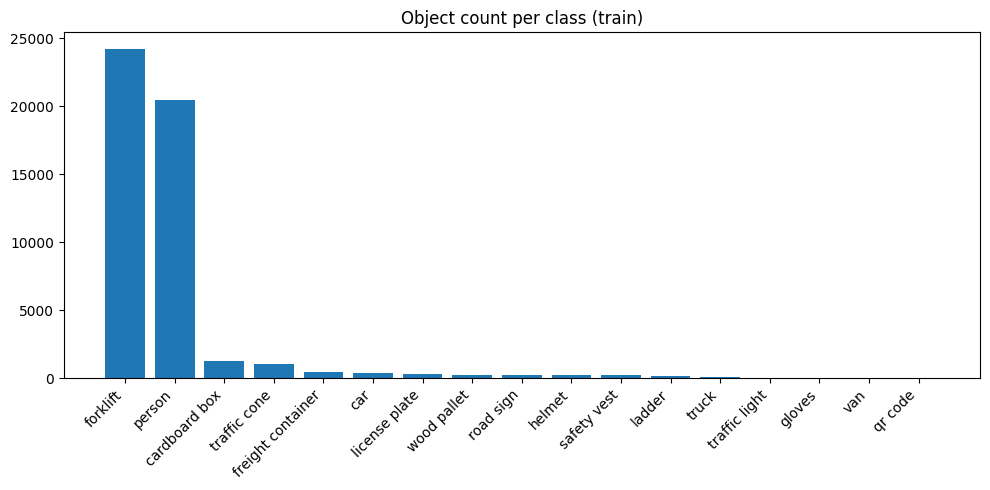

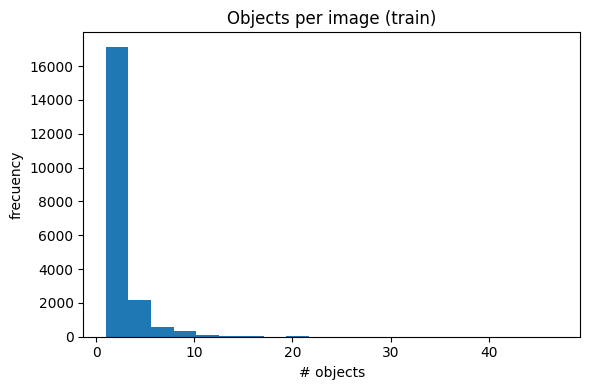

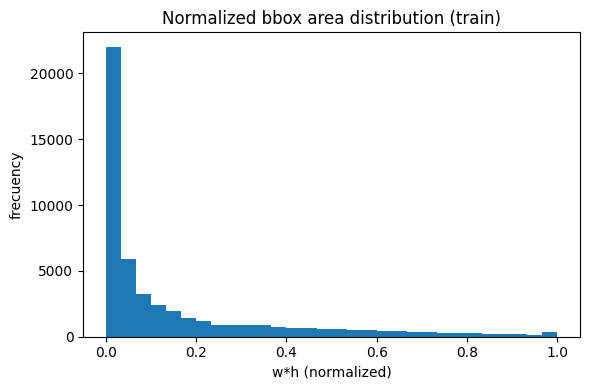

In [23]:
plt.figure(figsize=(10,5))
plt.bar(df_classes_train["class_name"], df_classes_train["count"])
plt.xticks(rotation=45, ha='right')
plt.title("Object count per class (train)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_objs_train["objects_per_image"], bins=20)
plt.title("Objects per image (train)")
plt.xlabel("# objects")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_areas_train["bbox_area_norm"], bins=30)
plt.title("Normalized bbox area distribution (train)")
plt.xlabel("w*h (normalized)")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

#### Analysis

[Image 1]
1. Severe class imbalance. Forklift (~25k) and Person (~20k) dominate the dataset. Most other classes have <1k instances, and some (<200) are borderline rare.
2. Impact on model. YOLO model will Learn forklifts and persons very quickly but undertrain small or rare objects. 
3. It is possible produce lower mAP50-95 for classes with low frequency and small area.


[Image 2]
1. Most images are low-density scenes. The distribution is extremely right-skewed. Most images contains <4 images.
2. Training implications. YOLO will learn faster on low-density images, but crowded scenes will remain challenging. 
3. mAP may be stable overall but usually lower on images with many objects, since those scenes are harder to detect accurately and the dataset contains relatively few of them.

[Image 3]
1. Most objects have very small bounding-box areas, indicating that the dataset contains many small objets/targets that are harder to detect consistently.
2. Even though the dataset contains many examples of small objects, their reduced size still makes them harder to localize precisely, so mAP for small-scale objects may be lower than for larger ones.

#### Analyze ratio wxh

In [29]:
def analyze_ratios(img_dir: str):
    ratios = []

    for _, lbl_path in yolo_label_paths(img_dir):
        labels = read_yolo_labels(lbl_path)
        for (_, cx, cy, w, h) in labels:
            if h > 0:
                ratios.append(w / h)

    return pd.DataFrame({"aspect_ratio": ratios})

In [30]:
df_ratios_train = analyze_ratios(train_dir)
df_ratios_train.describe()

aspect_ratio
count  49418.000000
mean       0.974316
std        0.727486
min        0.065385
25%        0.520000
50%        0.975889
75%        1.009174
max       12.233333

1. Mean 0.97 is almost 1. This means most boxes are almost square.
2. About 25% of objects are tall, with ratios below 0.52, which adds geometric variety for the model.
3. About 75% stay near 1.0, showing that wide objects exist but are not dominant.

#### Object Scale Categories

In [41]:
df_areas_train.describe()

bbox_area_norm
count    49418.000000
mean         0.155603
std          0.224430
min          0.000010
25%          0.010547
50%          0.045352
75%          0.203203
max          1.000000

The bbox area distribution is heavily skewed towards small values: 75% of objects occupy less than ~20% of the image area, and half of them less than ~5%

#### co-ocurrence

In [42]:
import numpy as np

num_classes = len(class_names)
cooc = np.zeros((num_classes, num_classes), dtype=int)

for _, lbl_path in yolo_label_paths(train_dir):
    labels = read_yolo_labels(lbl_path)
    cls_ids = list({lbl[0] for lbl in labels})  # unique classes in image
    
    for i in range(len(cls_ids)):
        for j in range(i+1, len(cls_ids)):
            a, b = cls_ids[i], cls_ids[j]
            cooc[a, b] += 1
            cooc[b, a] += 1  # symmetric

cooc_df = pd.DataFrame(cooc, index=class_names, columns=class_names)
cooc_df

car  cardboard box  forklift  freight container  gloves  \
car                  0              3       135                 12       0   
cardboard box        3              0       273                 51       3   
forklift           135            273         0                159      18   
freight container   12             51       159                  0       0   
gloves               0              3        18                  0       0   
helmet               9             27       138                  3      12   
ladder               3             27       174                 21       3   
license plate       30             39       276                 30       3   
person              66            189     10797                 81      18   
qr code              3              3         6                  3       0   
road sign           12             12       144                  6       0   
safety vest          3             24       135                  6      15   
traffic cone         9             42       204                  9       0   
traffic light        3              0        36                  0       3   
truck               60              3        78                  6       0   
van                  3              0        12                  0       0   
wood pallet          9             54       141                 18       3   

                   helmet  ladder  license plate  person  qr code  road sign  \
car                     9       3             30      66        3         12   
cardboard box          27      27             39     189        3         12   
forklift              138     174            276   10797        6        144   
freight container       3      21             30      81        3          6   
gloves                 12       3              3      18        0          0   
helmet                  0      21             15     132        3         12   
ladder                 21       0             30      87        0         24   
license plate          15      30              0     129        3         42   
person                132      87            129       0        3         60   
qr code                 3       0              3       3        0          0   
road sign              12      24             42      60        0          0   
safety vest            78      18             15     135        3          9   
traffic cone           42      18             27     171        0         12   
traffic light           3       0              3      18        0         21   
truck                   3       0              3      21        3          0   
van                     3       0              6       6        0          6   
wood pallet            24      15             15      90        3          3   

                   safety vest  traffic cone  traffic light  truck  van  \
car                          3             9              3     60    3   
cardboard box               24            42              0      3    0   
forklift                   135           204             36     78   12   
freight container            6             9              0      6    0   
gloves                      15             0              3      0    0   
helmet                      78            42              3      3    3   
ladder                      18            18              0      0    0   
license plate               15            27              3      3    6   
person                     135           171             18     21    6   
qr code                      3             0              0      3    0   
road sign                    9            12             21      0    6   
safety vest                  0            24              3      3    3   
traffic cone                24             0              0      0    0   
traffic light                3             0              0      0    0   
truck                        3             0    

1. "Person" is the universal co-object. Appears with almost every class with a high ocurrence with forklift.
2. Forklift has strong co-occurrence edges with many classes:
    * 159 with freight container
    * 174 with ladder
    * 276 with license plate
    * 138 with helmet
    * 204 with traffic cone

    It means, forklift scenes tend to include equipment, safety items, and containers.

3. Objects that appear together often (like forklift + person + cone) give Yolo helpful context, so recall usually improves in those scenes. Crowded scenes could also create more confusion and duplicate detections, which can lower precision and mAP.

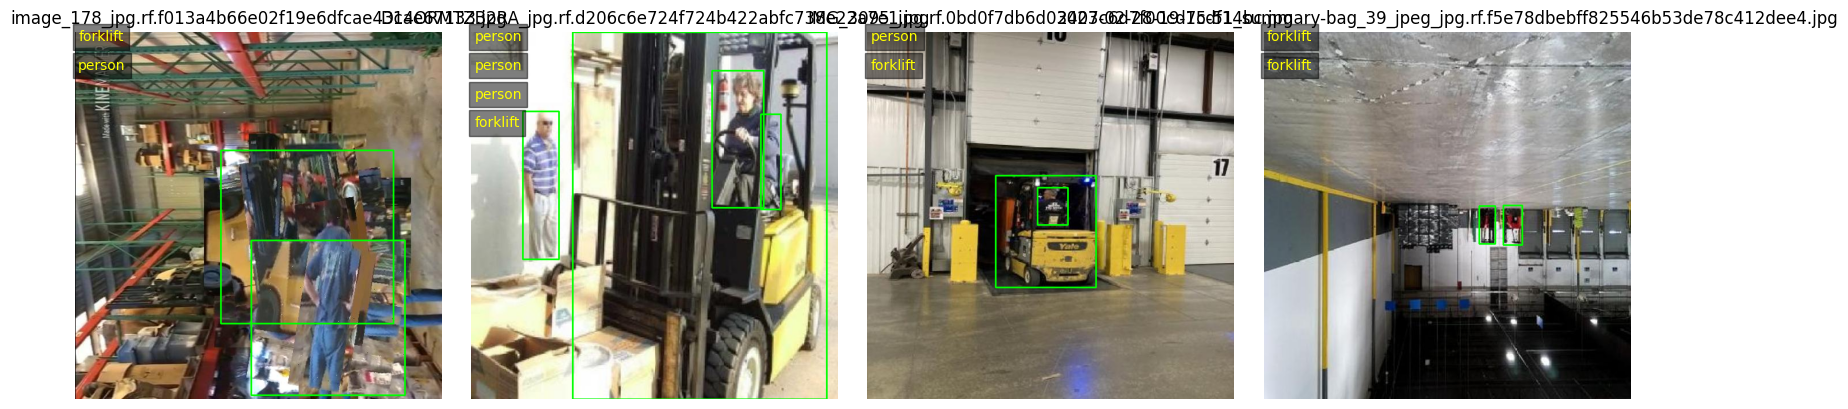

In [ ]:
def draw_yolo_bbox(img, bbox, color=(0,255,0), thickness=2):
    H, W = img.shape[:2]
    cx, cy, bw, bh = bbox
    x1 = int((cx - bw/2) * W)
    y1 = int((cy - bh/2) * H)
    x2 = int((cx + bw/2) * W)
    y2 = int((cy + bh/2) * H)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    return img

def visualize_samples(img_dir: str, class_names: list, n=4, seed=42):
    rng = random.Random(seed)
    pairs = yolo_label_paths(img_dir)
    sample = rng.sample(pairs, min(n, len(pairs)))
    fig, axes = plt.subplots(1, len(sample), figsize=(4*len(sample), 4))
    if len(sample) == 1:
        axes = [axes]

    for ax, (img_path, lbl_path) in zip(axes, sample):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        labels = read_yolo_labels(lbl_path)
        text_y = 15 # fix position of label
        for (cls_id, cx, cy, w, h) in labels:
            img = draw_yolo_bbox(img, (cx, cy, w, h))
            name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
            ax.text(5, text_y, name, color='yellow', bbox=dict(facecolor='black', alpha=0.5))
            text_y += 50 # if there are more than 1 label, move down

        ax.imshow(img)
        ax.set_title(Path(img_path).name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dir, class_names, n=4, seed=7)

### What methods would you use to verify the reliability of the labels?

1. First of all: Manual inspection, I could randomly check  10 or 12 images with their respective labels. I believe this would be my first sanity check.

2.  Data Validations.
    - 2.1 Statistical validations:
        * Anomalies as 100% of the image (or 0%)
        * Aspect-ratio histograms.
        * Distribution in objects, areas (check skewness)
    - 2.2. Automated Consistency Checks:
        * Impossible areas (0 widht, 0 height),
        * Negative dimensions
        * Boxes outside image boundaries
        * Duplicate annotations.
        * Bad yolo label formats.

3. Train a small YOLO model.
    * Analyze predictions where the model has high accuracy but disagrees with labels (or low confidence on supposedly clear examples).

4. Co-ocurrence. Certain pairs are expected (e.g person + forklift). But maybe unexpected combinations may indicate mislabeling.

5. Outlier Detection via Feature Embeddings. Extract a crop for each bounding box and compute an embedding using a pre-trained model (e.g. ResNet50 or the YOLO backbone) producing a matrix of shape (N, D). I then project these embeddings to (N, 2) with t-SNE or UMAP. Points that fall far from the cluster of their labeled class are likely annotation errors.


# 2. Training

In [3]:
DATA_YAML_PATH = "../data/data_train.yaml"

In [ ]:
# ==============================
# 🔧 HYPERPARAMETERS — EXPERIMENTAL SETUP
# ==============================

EPOCHS = 30
IMGSZ  = 640
BATCH  = 16
DEVICE = "cuda"        # or "cuda" if available

# Try YOLO11; if not available use YOLOv8
weights_try = ["yolo11n.pt", "yolov8n.pt"]
model = None
for w in weights_try:
    try:
        model = YOLO(w)
        print("Using:", w)
        break
    except Exception as e:
        print(f"Failed to load {w}: {e}")

assert model is not None, "Could not load a base model (yolo11n.pt / yolov8n.pt). Install ultralytics and make sure you have an active internet connection to download the weights."


# ==============================
# 🚀 TRAINING — BASELINE EXPERIMENT
# ==============================
# The results object contains metrics, charts, and run directory info.
# Feel free to adjust and rerun with different hyperparameters.

results = model.train(data=DATA_YAML_PATH, epochs=EPOCHS, imgsz=IMGSZ, batch=BATCH, device=DEVICE, workers=0, cache=False)
results

Using: yolo11n.pt
New https://pypi.org/project/ultralytics/8.3.234 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.74  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=../data/data_train.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=0, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=

train: Scanning D:\NIL\reto_latam_cv\cv_challenge\challenge\data\train\labels.cache... 20546 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20546/20546 [00:00<?, ?it/s]

train: WARNING  D:\NIL\reto_latam_cv\cv_challenge\challenge\data\train\images\-108_jpg.rf.f8e2654f2d7525e60f708b9eaeb6216c.jpg: 2 duplicate labels removed



val: Scanning D:\NIL\reto_latam_cv\cv_challenge\challenge\data\valid\labels.cache... 1967 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1967/1967 [00:00<?, ?it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000476, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.59G      1.194      2.296      1.429          4        640: 100%|██████████| 1285/1285 [13:27<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:42<00:00,  1.44it/s]


                   all       1967       4615      0.903     0.0825      0.096     0.0535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.68G      1.018      1.417      1.306          9        640: 100%|██████████| 1285/1285 [09:26<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:25<00:00,  2.44it/s]


                   all       1967       4615       0.71     0.0796     0.0948     0.0543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.56G     0.9803      1.262      1.284          6        640: 100%|██████████| 1285/1285 [08:55<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:16<00:00,  3.85it/s]


                   all       1967       4615      0.655      0.117      0.113     0.0644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.61G     0.9368      1.163      1.255          4        640: 100%|██████████| 1285/1285 [06:55<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.30it/s]


                   all       1967       4615      0.603      0.113      0.114     0.0635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.76G     0.8992       1.11      1.237          6        640: 100%|██████████| 1285/1285 [07:48<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:16<00:00,  3.80it/s]


                   all       1967       4615      0.787       0.15       0.13     0.0751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.87G     0.8673      1.048      1.208          9        640: 100%|██████████| 1285/1285 [07:49<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:28<00:00,  2.16it/s]


                   all       1967       4615        0.7      0.136      0.127     0.0726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.65G     0.8452       1.01      1.196          4        640: 100%|██████████| 1285/1285 [08:21<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.29it/s]


                   all       1967       4615      0.777      0.151      0.147     0.0891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.68G     0.8319     0.9824      1.188         22        640: 100%|██████████| 1285/1285 [07:13<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:25<00:00,  2.39it/s]


                   all       1967       4615      0.729      0.142      0.153     0.0918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.65G     0.8149     0.9609      1.176          7        640: 100%|██████████| 1285/1285 [09:15<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:21<00:00,  2.89it/s]

                   all       1967       4615       0.82      0.133      0.157     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.93G     0.8003     0.9348      1.164         13        640: 100%|██████████| 1285/1285 [09:45<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.24it/s]


                   all       1967       4615      0.746      0.179      0.164      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.73G     0.7844     0.9195      1.157          4        640: 100%|██████████| 1285/1285 [08:56<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:25<00:00,  2.42it/s]


                   all       1967       4615      0.706      0.198      0.181      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.78G     0.7752     0.8941      1.152          9        640: 100%|██████████| 1285/1285 [08:59<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:28<00:00,  2.19it/s]

                   all       1967       4615      0.735      0.211      0.189      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.79G      0.768     0.8787      1.147         21        640: 100%|██████████| 1285/1285 [10:35<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:23<00:00,  2.59it/s]

                   all       1967       4615      0.623      0.232      0.195      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.65G     0.7604     0.8658      1.136         11        640: 100%|██████████| 1285/1285 [08:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.36it/s]


                   all       1967       4615      0.743       0.22      0.201      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.87G     0.7531     0.8492      1.131         12        640: 100%|██████████| 1285/1285 [06:17<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.28it/s]

                   all       1967       4615      0.688      0.223      0.207      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.83G     0.7462     0.8407      1.129          9        640: 100%|██████████| 1285/1285 [08:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.36it/s]

                   all       1967       4615      0.695      0.224      0.207      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       2.7G      0.732     0.8157      1.121          1        640: 100%|██████████| 1285/1285 [07:10<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:25<00:00,  2.41it/s]

                   all       1967       4615      0.724      0.229      0.203       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.56G     0.7225     0.8067      1.114         10        640: 100%|██████████| 1285/1285 [06:13<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:19<00:00,  3.18it/s]


                   all       1967       4615      0.749      0.208       0.21      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.78G     0.7174     0.7938      1.111          6        640: 100%|██████████| 1285/1285 [05:35<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.39it/s]


                   all       1967       4615      0.629      0.226      0.218      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       2.7G     0.7114     0.7854      1.105          8        640: 100%|██████████| 1285/1285 [05:53<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.39it/s]

                   all       1967       4615      0.719      0.224      0.223       0.15


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.59G     0.7299     0.7611      1.112          3        640: 100%|██████████| 1285/1285 [05:13<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:13<00:00,  4.46it/s]

                   all       1967       4615      0.556       0.25      0.231      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.54G     0.7177     0.7344        1.1          3        640: 100%|██████████| 1285/1285 [05:11<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.28it/s]

                   all       1967       4615      0.522      0.252      0.237      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.54G     0.7102     0.7183      1.096          2        640: 100%|██████████| 1285/1285 [05:09<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.33it/s]

                   all       1967       4615      0.616      0.285      0.251      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.54G     0.6981     0.7045      1.088          3        640: 100%|██████████| 1285/1285 [05:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.25it/s]


                   all       1967       4615      0.583      0.251      0.241       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.54G     0.6927     0.6914      1.084          9        640: 100%|██████████| 1285/1285 [05:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.29it/s]


                   all       1967       4615      0.645      0.255      0.253      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.56G     0.6859     0.6772      1.078          9        640: 100%|██████████| 1285/1285 [05:09<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:13<00:00,  4.47it/s]

                   all       1967       4615      0.673      0.251      0.258      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.54G     0.6779     0.6645       1.07          3        640: 100%|██████████| 1285/1285 [05:09<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.36it/s]

                   all       1967       4615      0.636      0.276      0.266      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.52G     0.6717     0.6542      1.066          5        640: 100%|██████████| 1285/1285 [05:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.26it/s]

                   all       1967       4615      0.648      0.264      0.262      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.55G     0.6623     0.6456      1.063          3        640: 100%|██████████| 1285/1285 [05:08<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:13<00:00,  4.48it/s]

                   all       1967       4615      0.636      0.267       0.26      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.57G     0.6555     0.6334      1.057          3        640: 100%|██████████| 1285/1285 [05:09<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:14<00:00,  4.38it/s]

                   all       1967       4615      0.651      0.261      0.261      0.175



30 epochs completed in 3.768 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 5.5MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.74  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 238 layers, 2,585,467 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [00:15<00:00,  4.09it/s]


                   all       1967       4615      0.656      0.261      0.262      0.176
                   car         14         31      0.406      0.742      0.435      0.279
         cardboard box         18         64      0.424      0.125      0.139     0.0937
              forklift       1967       2310      0.882      0.916      0.956       0.73
     freight container         13         23      0.403      0.087     0.0894     0.0464
                gloves          4          6          1          0     0.0318     0.0286
                helmet         15         22      0.364      0.273      0.259      0.159
                ladder         19         23          1          0     0.0715     0.0415
         license plate         21         23      0.432      0.087      0.107     0.0814
                person       1029       1938      0.761      0.712      0.784      0.478
             road sign         16         19          1          0     0.0141     0.0112
           safety ves

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002CCEDE91C60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.04

### ✏️ Discussion

Explain:
1. Why did you choose these hyperparameters?  
2. How do they affect training time, GPU/CPU usage, and accuracy?  
3. What would you try differently if you had more time or resources?

Answers

1.  These hyperparameters are configured for those reasons:
    * workers = 0, just for use yolo11 without multiprocessing bug on windows
    * cache = False just to save time.

    * EPOCH = 30: 
        - The dataset has strong class imbalance (forklift and person dominate) and many tiny objects. YOLO needs enough iterations to learn minority classes without overfitting to the dominant ones. In my prior experience 20-30 epochs gives a good baseline, I am playing safe with 30 epochs
    * IMGSZ = 640:
        - The images resolution of the dataset are 640×640. Keeping the original size avoids interpolation artifacts and improves detection of the many small objects observed during the EDA.
    
    * BATCH = 16:
        - The dataset shows large variation in object counts per image (from 1 to close to 47). A batch size of 16 smooths out these differences and produces more stable gradients and still fits comfortably on my GPU. It balances speed and memory. 

    * DEVICE = "cuda":
        - YOLO training on CPU is extremely slow, but using GPU ensures a reasonable training time.

2. This was explain it above. In concise, 
    * More EPOCH takes more time, even when the first epoch takes much time than the next ones.
    * IMGSZ: Higher resolution increases compute cost per image, so training runs slower. It costs more in memory because we need to save more pixels, in terms of accuracy the upside is better accuracy, especially for small objects, which dominate this dataset. A larger image size increases the number of pixels per object, especially for small objects, which improves bounding-box precision but as I said earlier, the trade-off is higher memory usage.
    * A batch of 16 keeps GPU utilization high and training throughput stable. It reduces gradient noise compared to very small batches, improving convergence, while still fitting comfortably in memory. Larger batches would speed up training slightly but require more VRAM and it may reduce generalization.
    * CUDA use my GPU. Training on GPU dramatically reduces training time vs. CPU.


3. If I had more time and resources I would:
    - Only if allowed, I would expand the dataset by collecting additional examples for minority classes.
    - Train longer and test larger models. Yolo11n is the (n)ano version of Yolo11. I would move to yolo11l or yolo11x because bigger backbones would help with minority classes and crowded scenes.
    - Use a higher image resolution (768x768). Even though the images are originally 640x640, training at a higher resolution of 768x768 could still improve performance. Upsampling increases the spatial resolution of the feature maps and gives the detector more prediction points, which helps with tiny objects.
    - Use workers. I would increase workers from 0 to 4–8 to speed up data loading once stable training is achieved. I had problems with Windows multiprocessing.
    - Run a hyperparameter sweep using Ray Tune, which is natively supported in Ultralytics (as documented in https://docs.ultralytics.com/integrations/ray-tune/#ray-tune). This would allow me to automatically search over key parameters such as lr0, optimizer, epochs, and patience, and select the configuration that maximizes mAP50–95 without manual tuning.

# 3. Evaluation


> 👉 **Task:** Evaluate your trained model using the validation set defined in `data.yaml`.

Run the following cell to compute key performance metrics
Then, summarize your results and provide your interpretation.

**Guidelines for your analysis:**
- **Quantitative metrics** 
- **Error analysis**
- **Next steps**

In [ ]:
model = YOLO("runs/detect/train2/weights/best.pt")

In [23]:
# Model metrics

# - Run model validation on the dataset below.
metrics = model.val(data=DATA_YAML_PATH, imgsz=IMGSZ, device=DEVICE)

# - Capture metrics and save a summary to artifacts/metrics_summary.json.
try:
    summary = {
        "metrics/mAP50-95(B)": float(metrics.results_dict.get("metrics/mAP50-95(B)") if hasattr(metrics, "results_dict")
                                    else getattr(metrics, "map", float("nan"))), # to work with yolov11 and yolov8
        "metrics/mAP50(B)"   : float(metrics.results_dict.get("metrics/mAP50(B)") if hasattr(metrics, "results_dict")
                                    else getattr(metrics, "map50", float("nan"))), # to work with yolov11 and yolov8
        "nc": int(nc),
        "classes": class_names,
        "epochs": EPOCHS,
        "imgsz": IMGSZ,
    }
except Exception as e:
    summary = {"error": str(e)}
    
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/metrics_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

summary


Ultralytics 8.3.74  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)


val: Scanning D:\NIL\reto_latam_cv\cv_challenge\challenge\data\valid\labels.cache... 1967 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1967/1967 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:16<00:00,  7.31it/s]


                   all       1967       4615      0.656      0.261      0.262      0.176
                   car         14         31      0.406      0.742      0.438      0.279
         cardboard box         18         64      0.423      0.125      0.143     0.0938
              forklift       1967       2310      0.883      0.916      0.956       0.73
     freight container         13         23      0.403      0.087     0.0893     0.0482
                gloves          4          6          1          0     0.0318     0.0286
                helmet         15         22      0.362      0.273      0.258      0.166
                ladder         19         23          1          0     0.0715     0.0405
         license plate         21         23      0.431      0.087      0.107     0.0825
                person       1029       1938      0.762      0.712      0.783      0.477
             road sign         16         19          1          0      0.014     0.0113
           safety ves

{'metrics/mAP50-95(B)': 0.17627143864717815,
 'metrics/mAP50(B)': 0.26208689006507674,
 'nc': 17,
 'classes': ['car',
  'cardboard box',
  'forklift',
  'freight container',
  'gloves',
  'helmet',
  'ladder',
  'license plate',
  'person',
  'qr code',
  'road sign',
  'safety vest',
  'traffic cone',
  'traffic light',
  'truck',
  'van',
  'wood pallet'],
 'epochs': 30,
 'imgsz': 640}

PR_curve.png


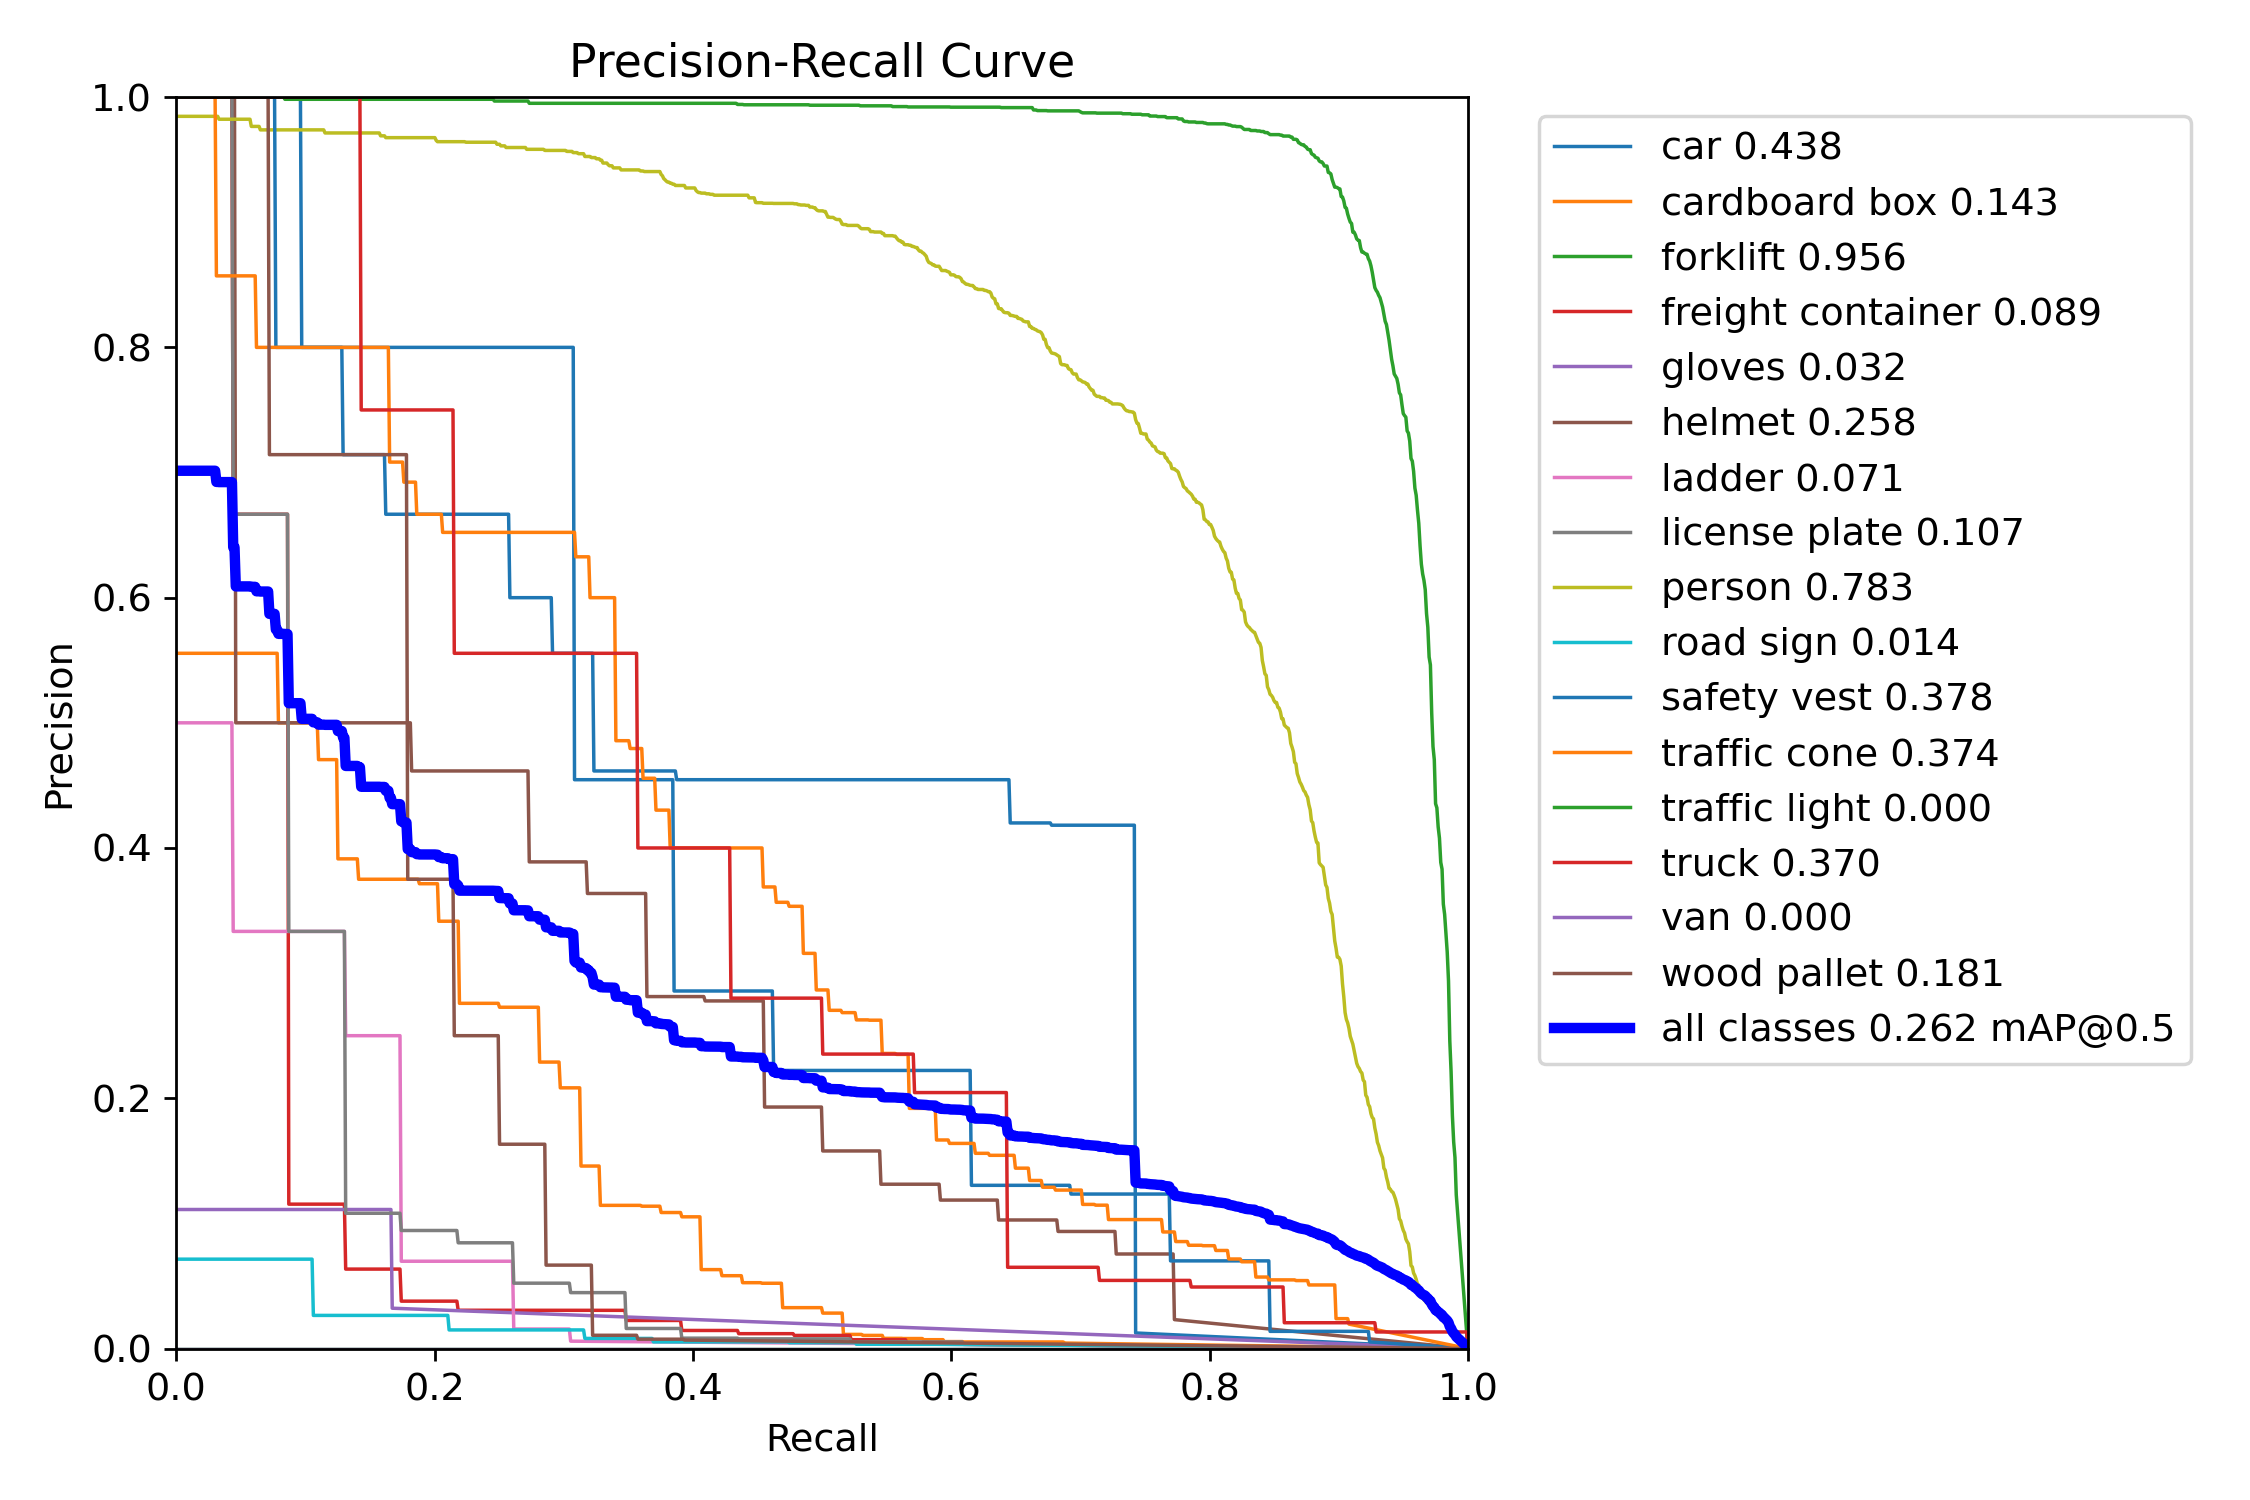

confusion_matrix.png


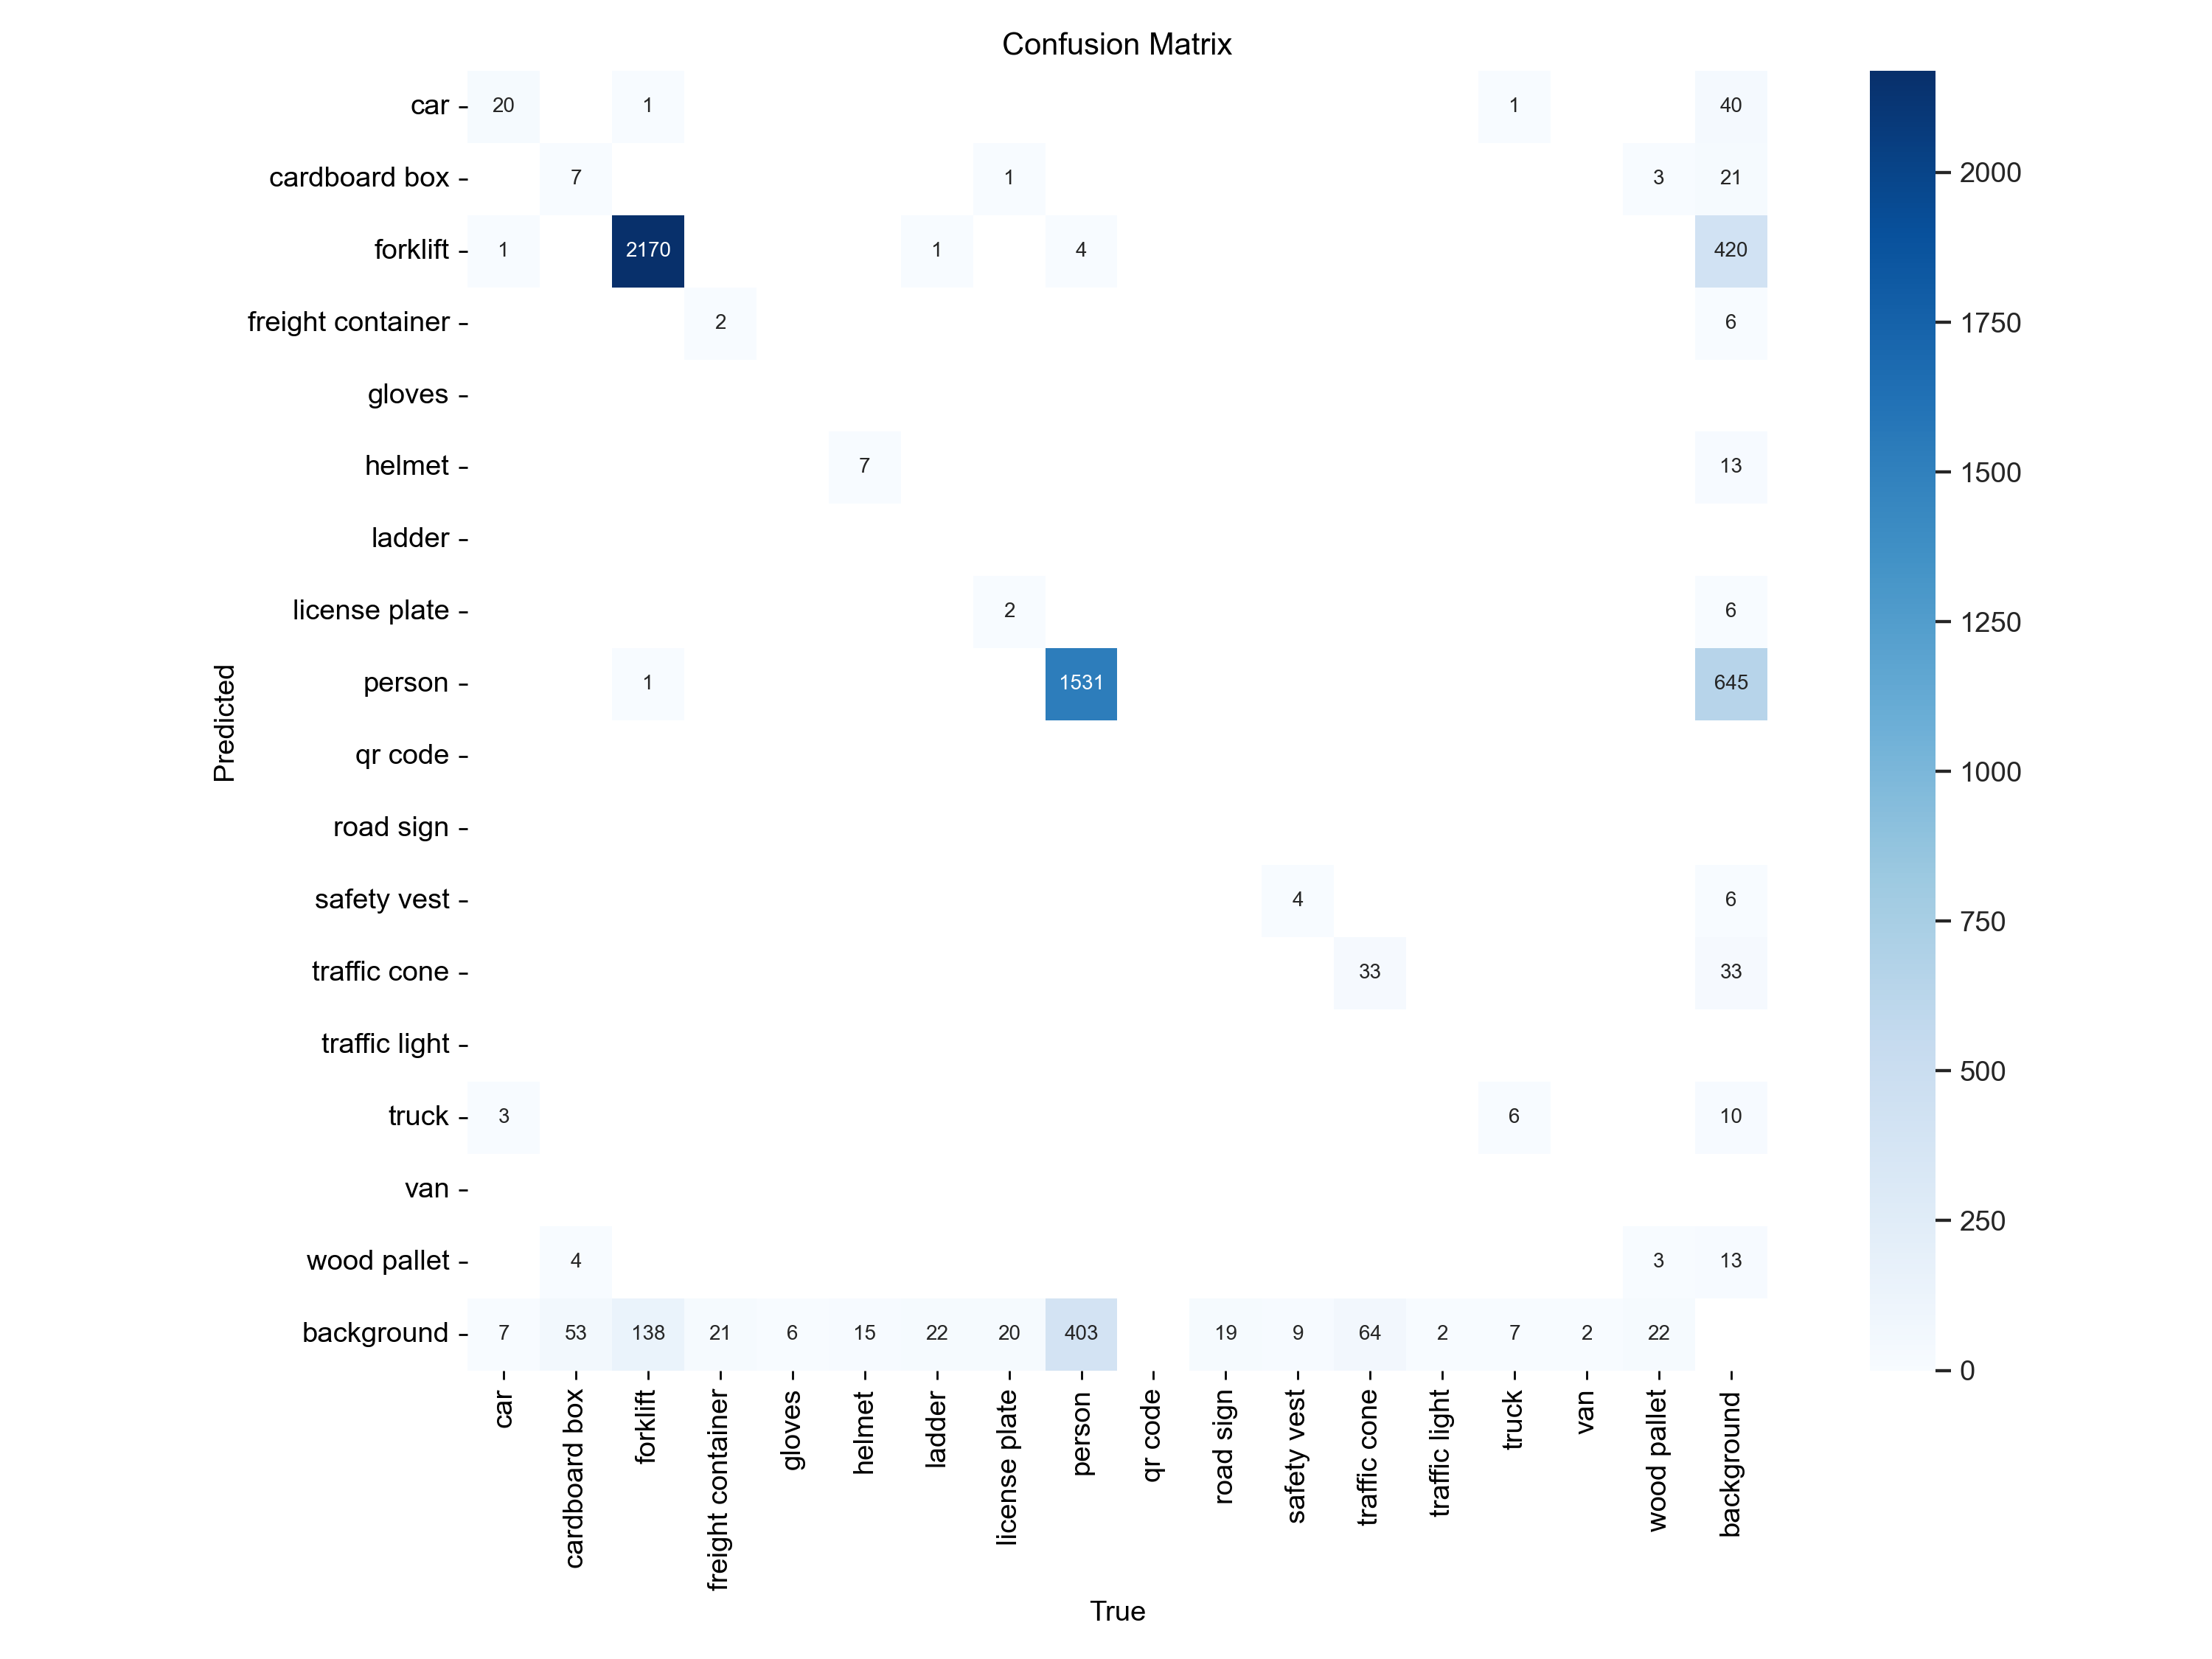

confusion_matrix_normalized.png


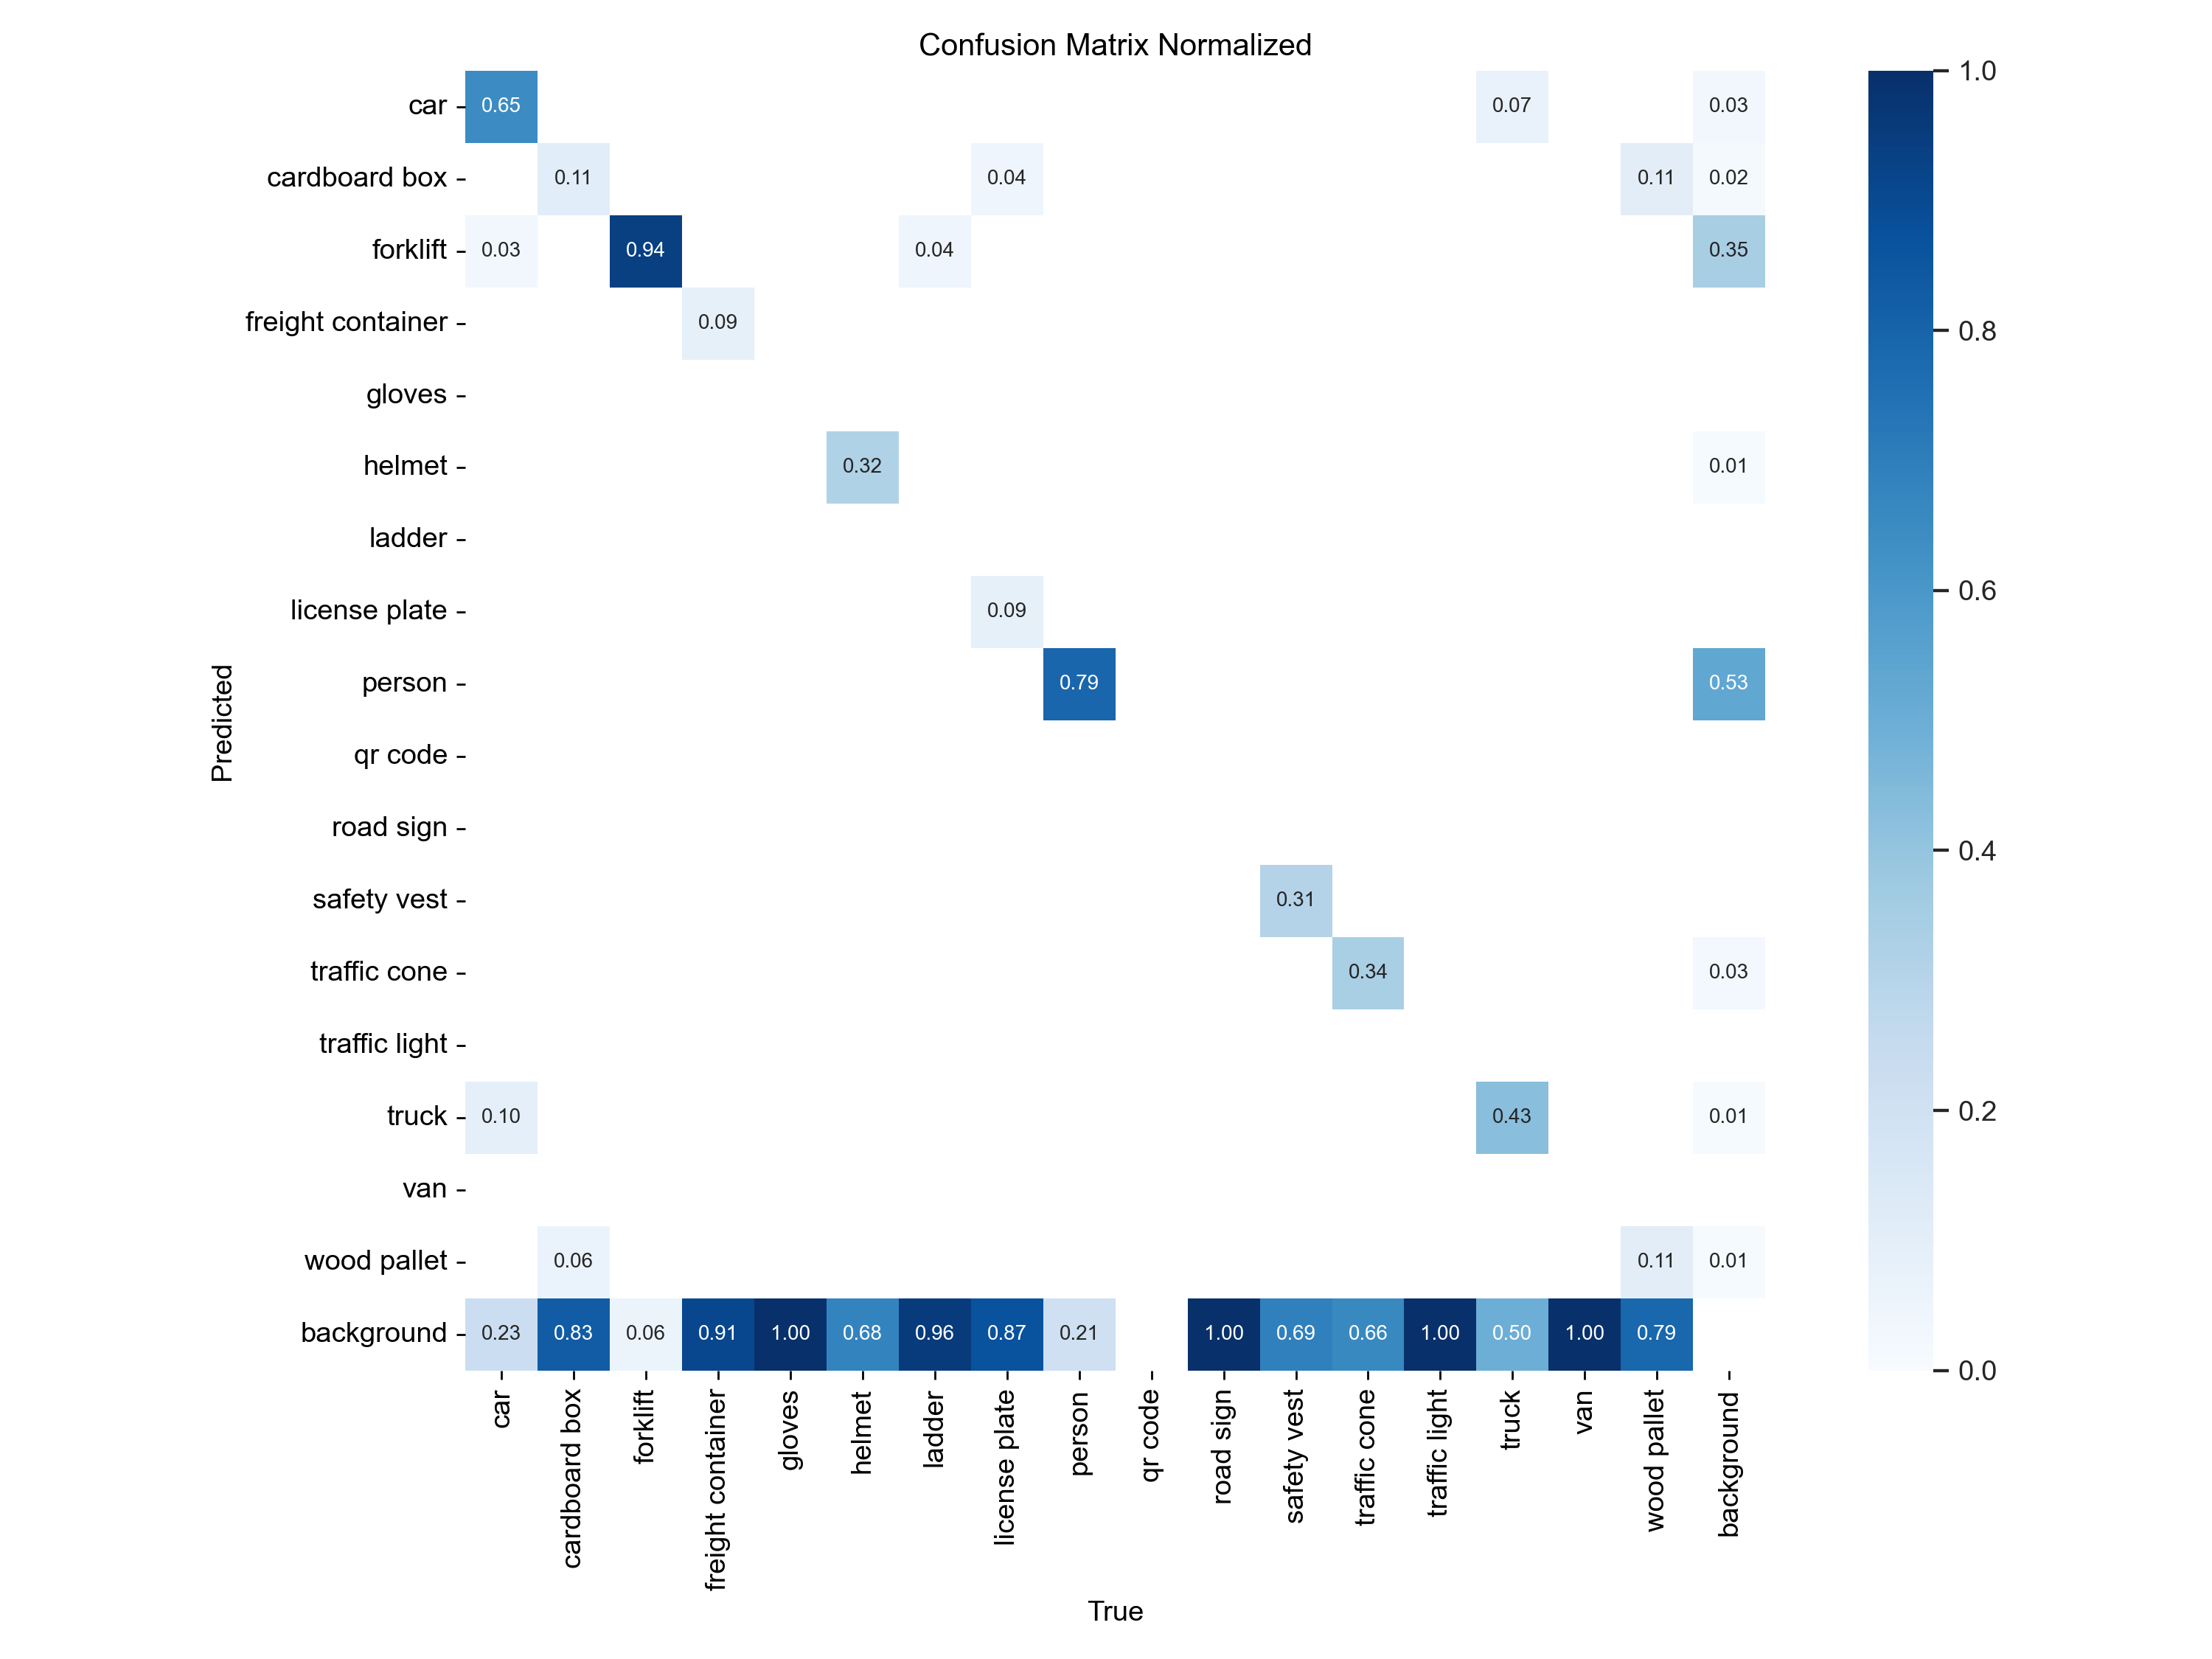

F1_curve.png


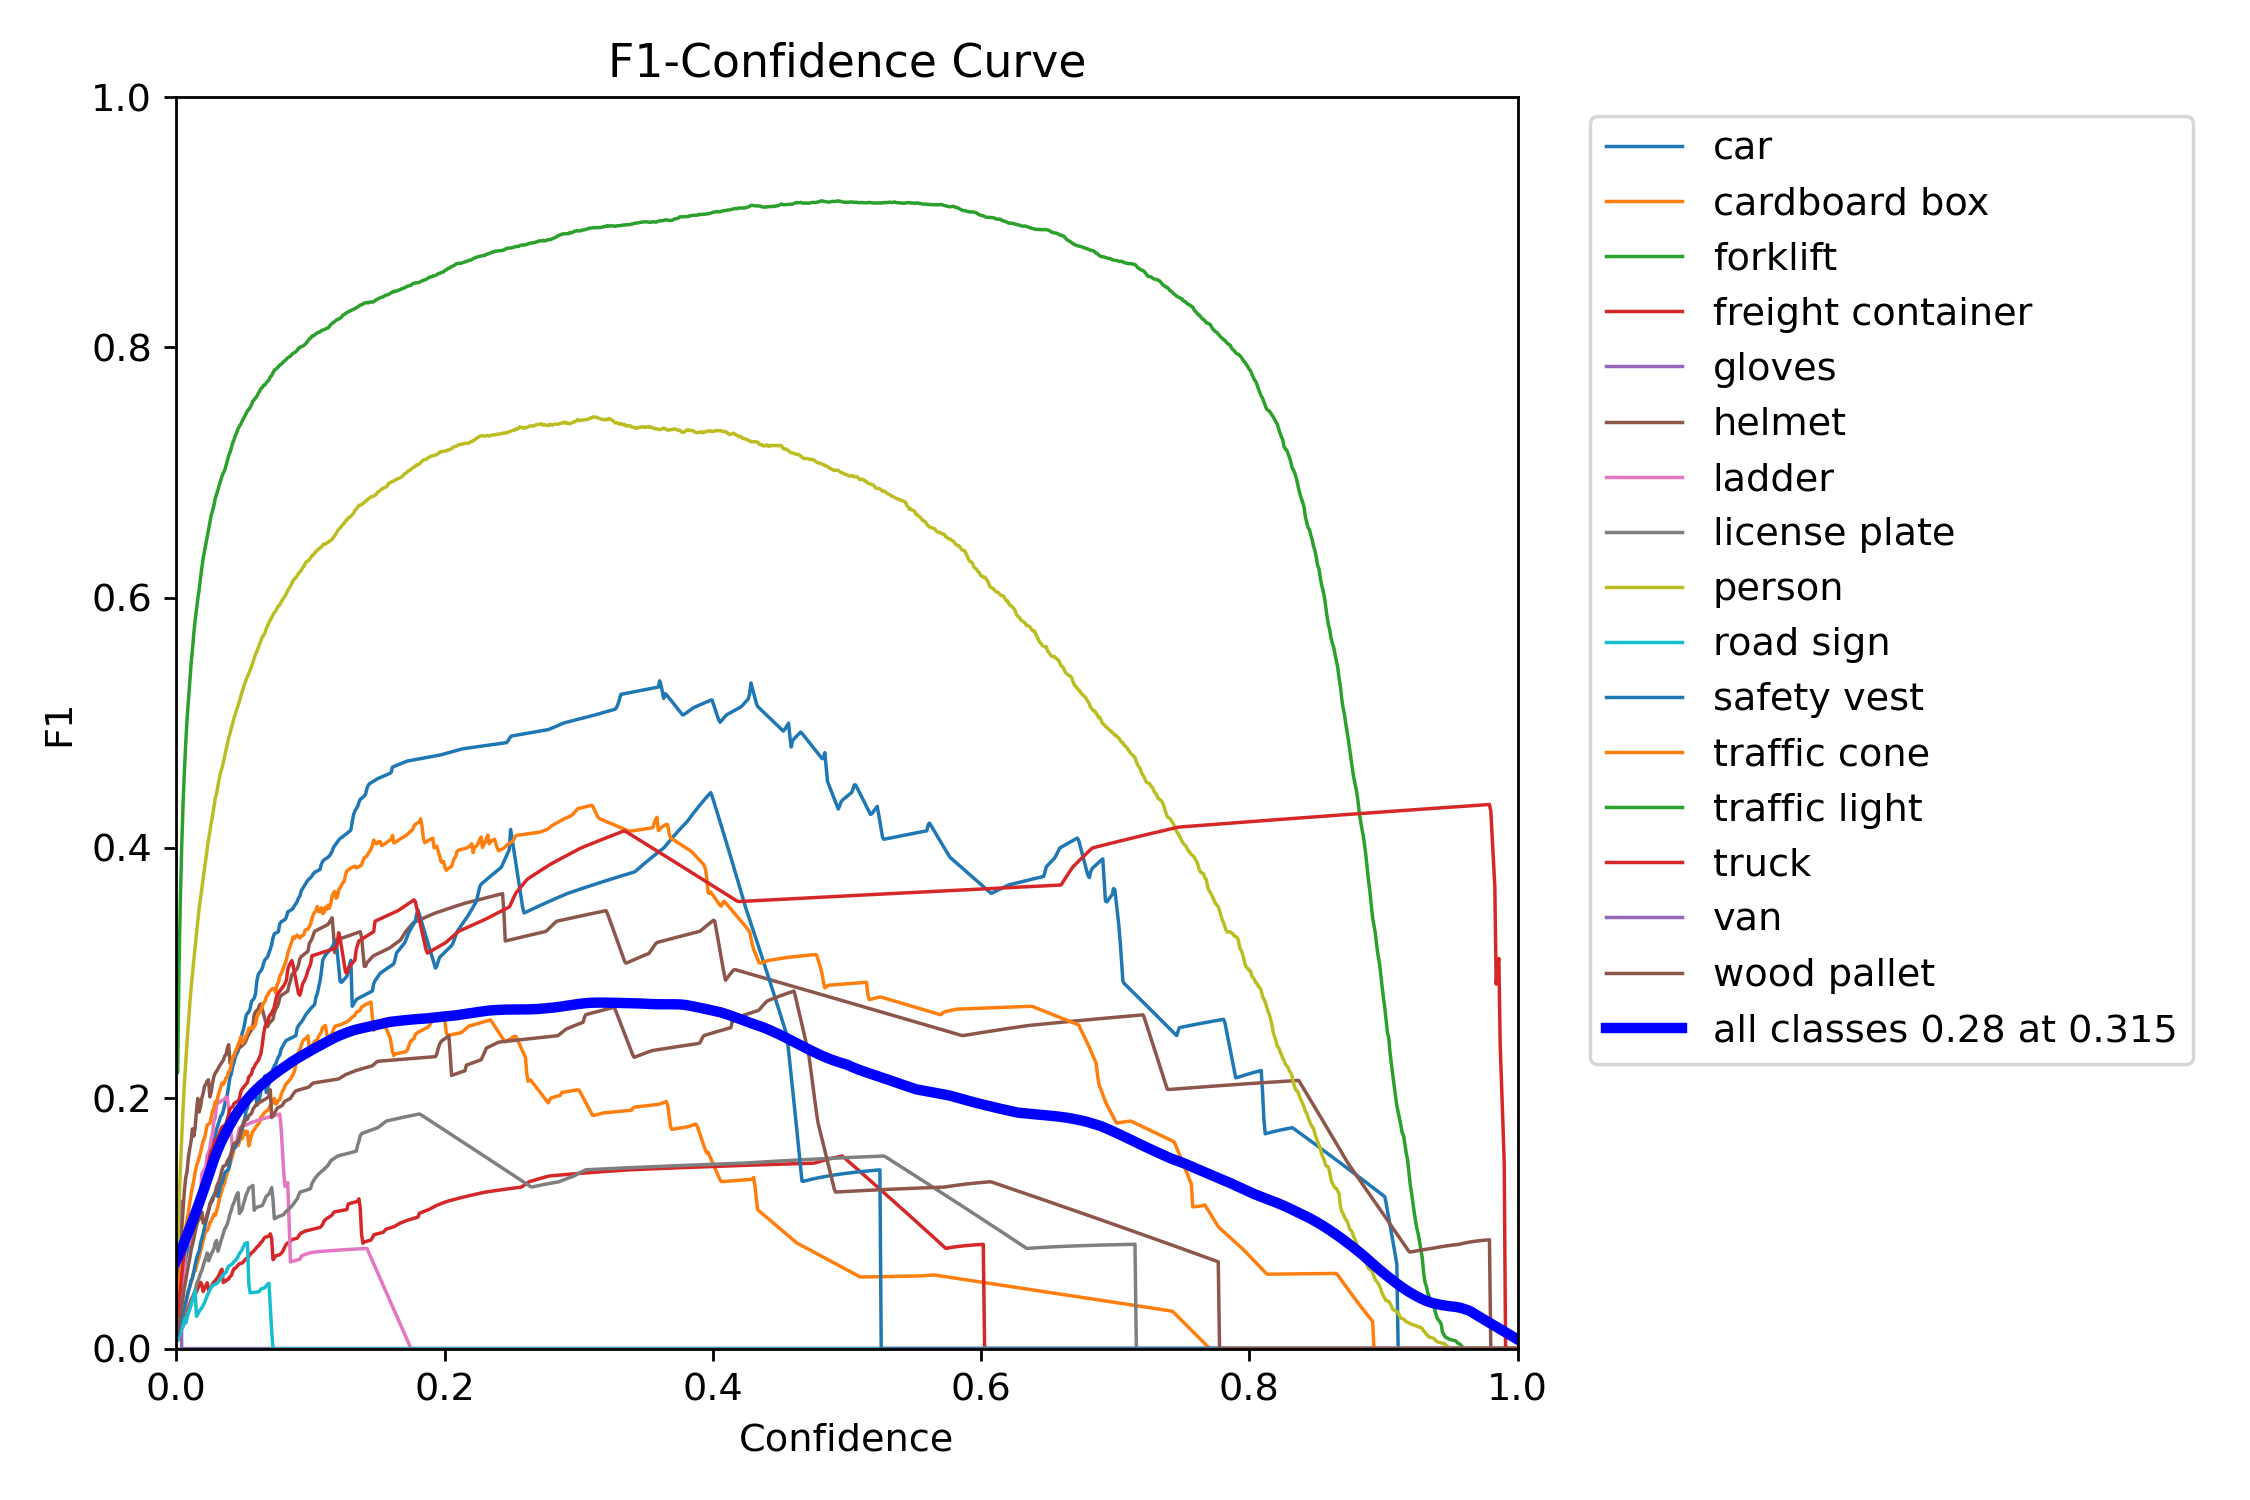

P_curve.png


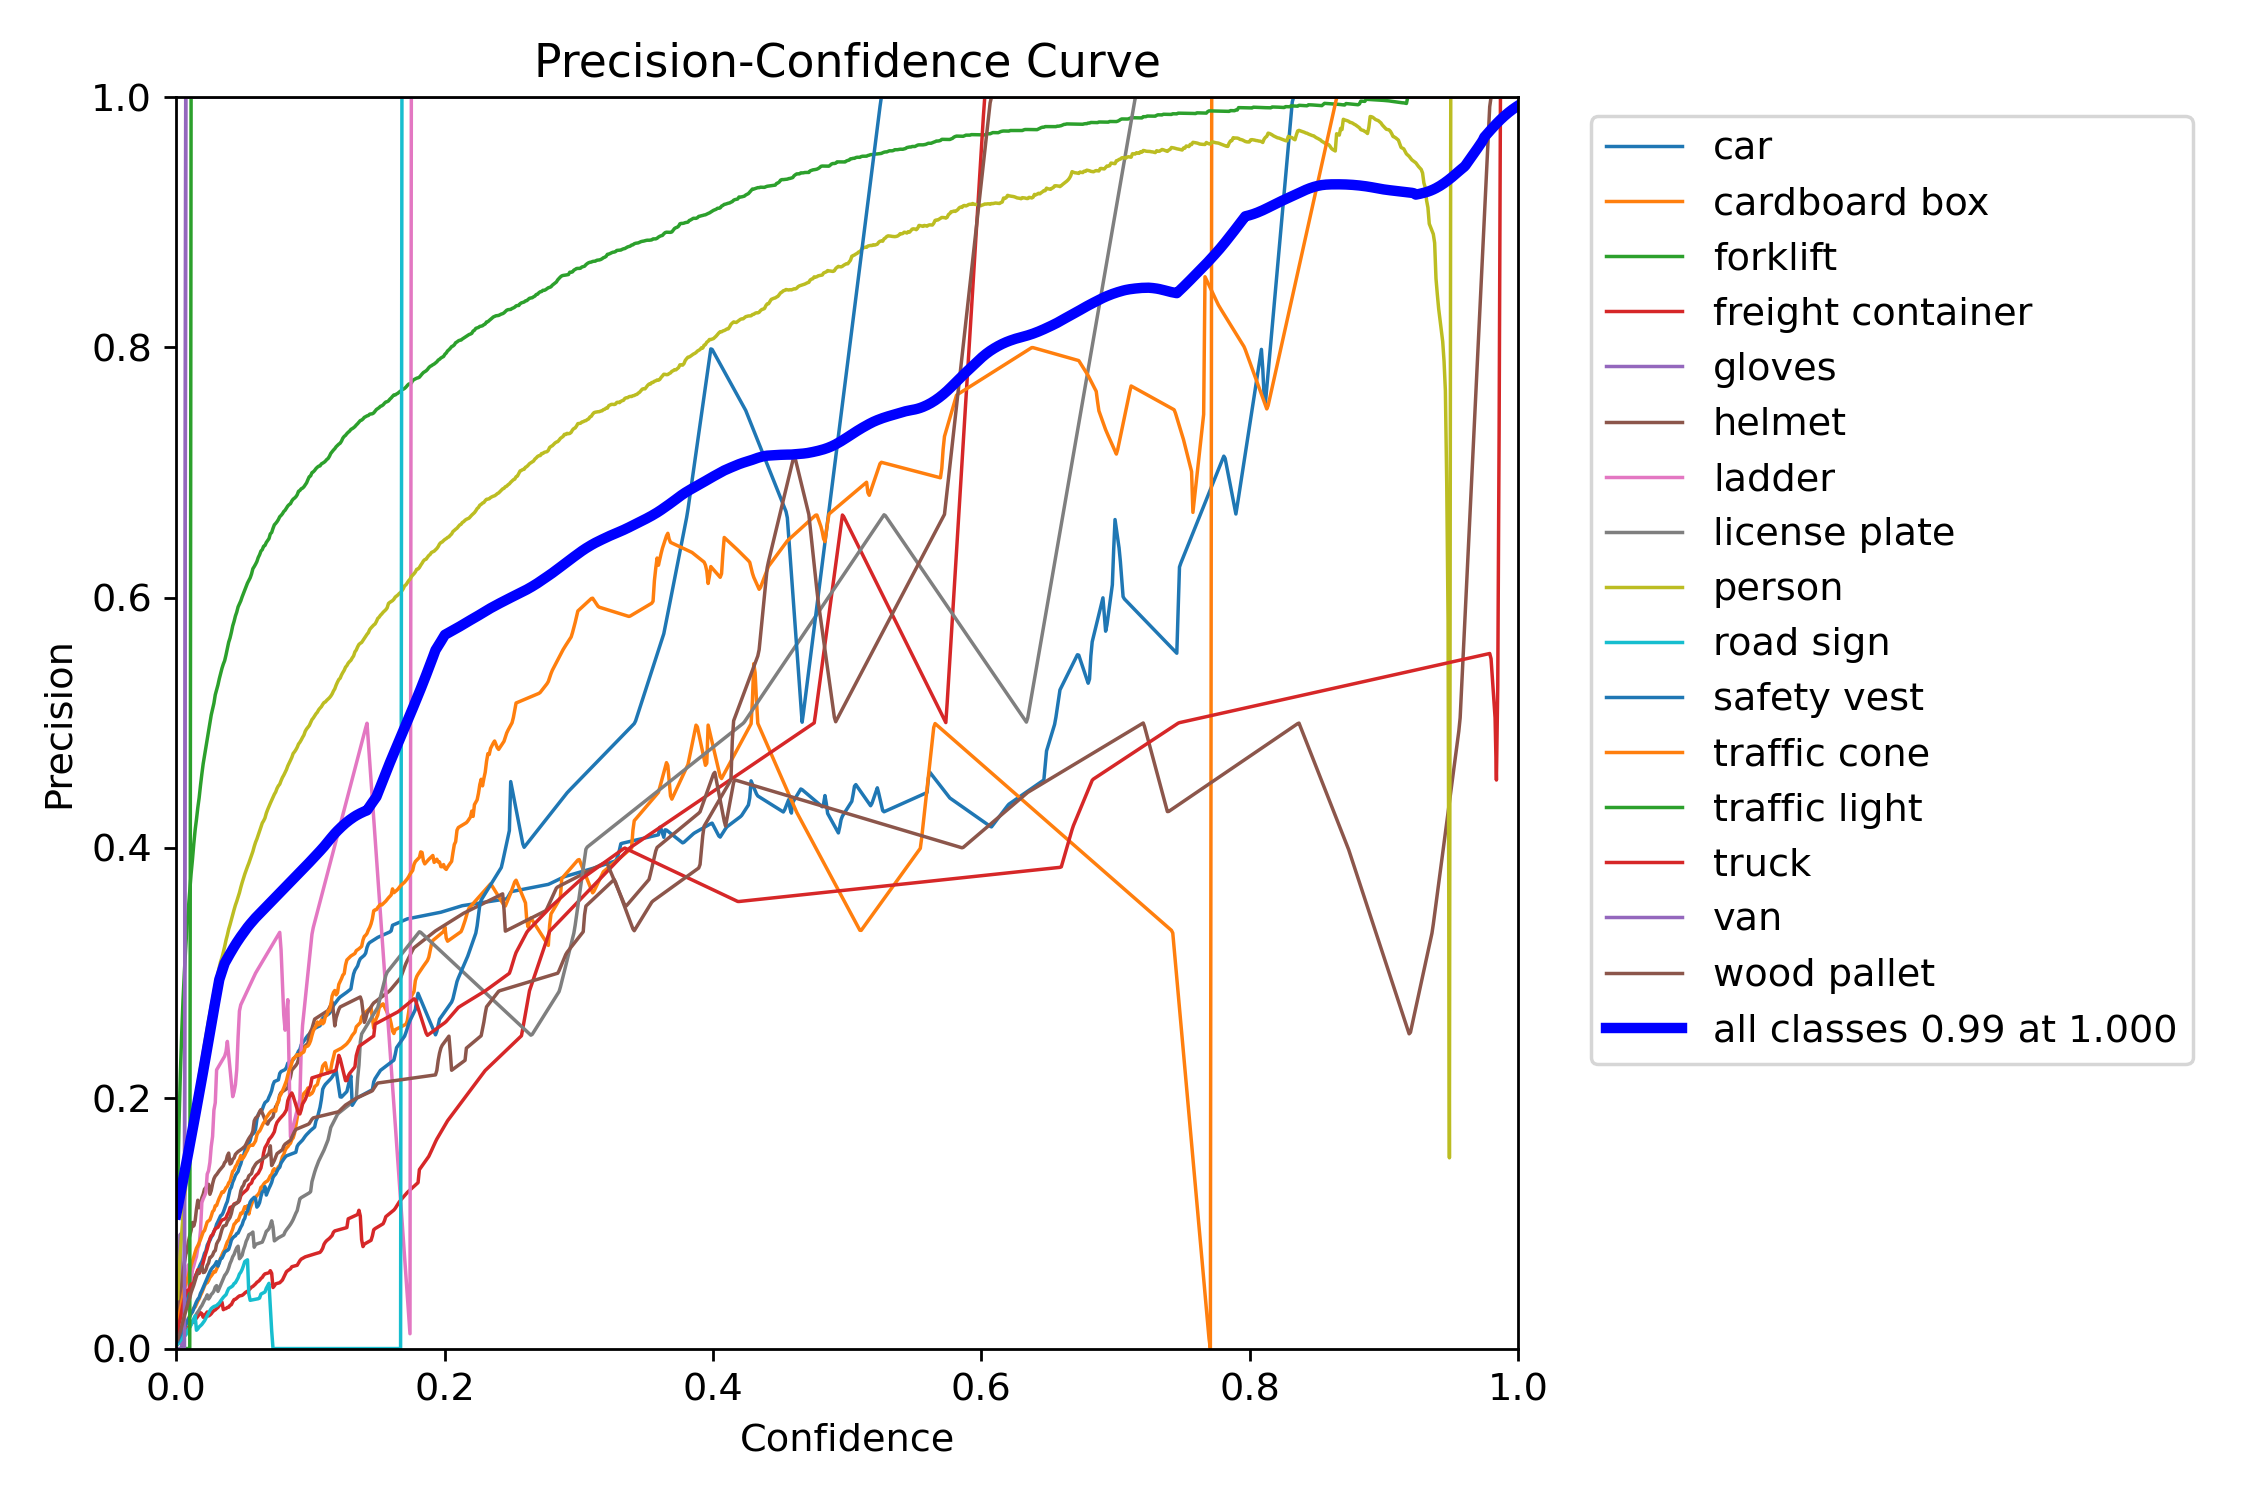

R_curve.png


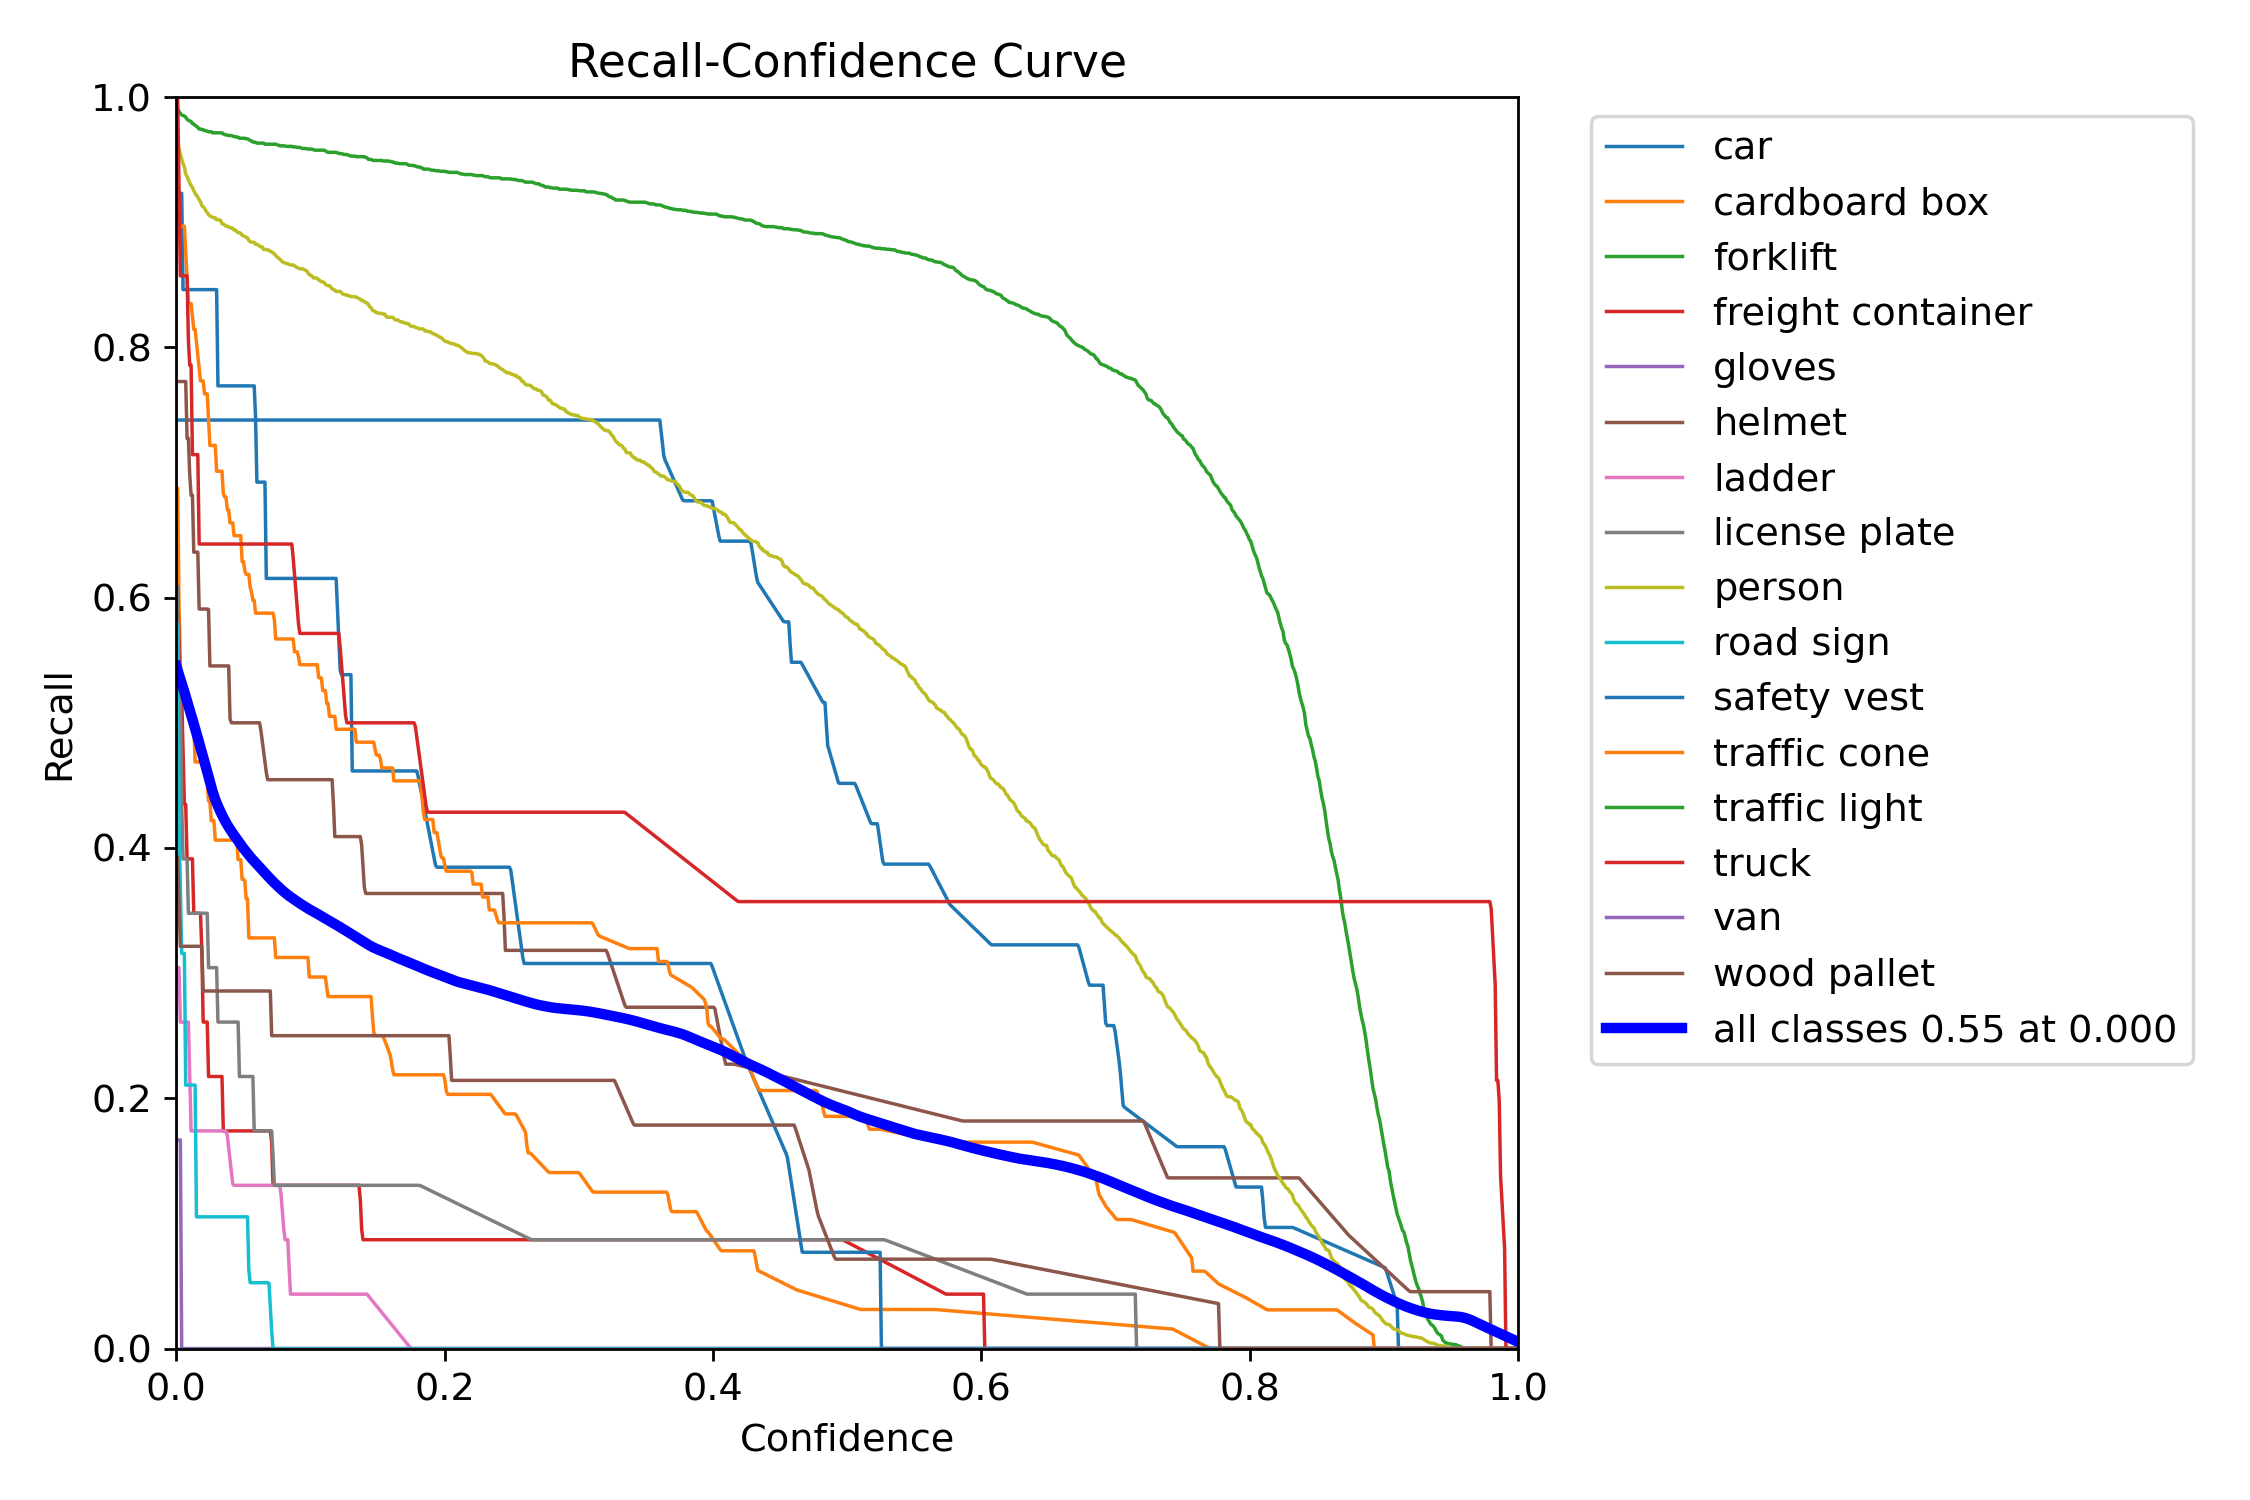

In [39]:
# Visual analysis (PR curves, confusion matrix).
from IPython.display import Image, display

plot_dir = "runs/detect/val"

plots = [
    "PR_curve.png",
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "F1_curve.png",
    "P_curve.png",
    "R_curve.png"
]

for p in plots:
    path = os.path.join(plot_dir, p)
    if os.path.exists(path):
        print(p)
        display(Image(path, width=870))
    else:
        print(f"[X] Missing:", path)

### ✏️ Metrics Interpretation and Analysis

Provide a short written analysis here:

1. **Quantitative Summary:**
   - What are your `mAP50` and `mAP50-95` values?
   - Which classes achieved the highest and lowest detection performance?

2. **Qualitative Analysis:**
   - Describe common failure cases (e.g., small objects missed, overlapping detections, background confusion).
   - Were there any label quality issues or inconsistencies you observed?

3. **Improvement Proposals:**
   - Suggest at least two improvements (data augmentation, loss tuning, class balancing, etc.).
   - How would you validate whether these changes actually help?


Answers

1. Quantitative Summary.
    * mAP50: 0.262 and mAP50-95: 0.176.
    * Best-performing classes:
        - forklift      -> P: 0.883, R: 0.916, mAP50: 0.956, mAP50-95: 0.73
        - person        —> P: 0.762, R: 0.712, mAP50: 0.783, mAP50-95: 0.477
        Strong performances due to high class frequency and consistent appearance.
    * Lowest-performing classes (ordered by mAP50-95):
        - traffic light     -> mAP50: 0,      mAP50-95: 0
        - van               -> mAP50: 0,      mAP50-95: 0
        - road sign         -> mAP50: 0.014,  mAP50-95: 0.0113
        - gloves            -> mAP50: 0.0318, mAP50-95: 0.0286
        - ladder            -> mAP50: 0.0715, mAP50-95: 0.0405
        - freight container -> mAP50: 0.0893, mAP50-95: 0.0482
        Extremely low instance counts (traffict light and van have just 2 instances) and small object sizes, leading to underfitting

2. Qualitative Analysis:
    * Missing small objects. Very small objects (traffic light, license plate, road sign) are frequently missed due to resolution limits. 
    * Class imbalance. traffic light, license plate, road sign: They were the classes with least samples as we check in the section "How is the date distribuited?"
    * High intra-class variability. Categories such as cardboard box or wood pallet vary widely in texture, size, and viewpoint, reducing mAP stability.

    * Label quality issues.
        - Helmet is normally a visually simple class, so the unusually low mAP50 (0.258) and mAP50-95 (0.166) suggest annotation inconsistencies rather than model limitations.
        - Safety vests are very easy to recognize (bright colors, rectangular shapes), so the unusually low recall suggests inconsistent or missing labels rather than model limitations

3. Improvement Proposals:
    * Definitely, I would increase the input resolution (768 or 960). This should help the model learn more features for small objects.
    * I would oversample minority classes to ensure they appear more frequently during training.
    * Perform a quick manual label pass on inconsistent categories for minor classes. I would open the images where the model fails and check for annotation issues such as poorly cropped helmets, missing safety-vest labels, inconsistent license-plate boxes, or incomplete "cardboard box" annotations.
    * Clean and refine minority-class annotations. After an inspection, some minority classes contain low-quality images or imperfect bounding boxes. Then, I would oversample the clean samples and apply stronger augmentations specifically to them (contrast adjustments, Mosaic augmentation, color jitter, etc).

    * The steps above can be summarized as a self-training loop:
        0. Train an initial model
        1. Predict on the training dataset
        2. Inspect failures in minority classes
        3. Clean the annotations. When the sample is extremely bad remove it
        4. Oversample only the clean minority-class samples
        5. Retrain


    * I would compare the updated model against the baseline using:
        - per-class recall and mAP50-95 (especially for small or rare classes)
        - PR curve shifts
        - confusion matrix changes
        - Any improvement must outperform the baseline in these metrics.

### Example of a low resolution/ noisy image

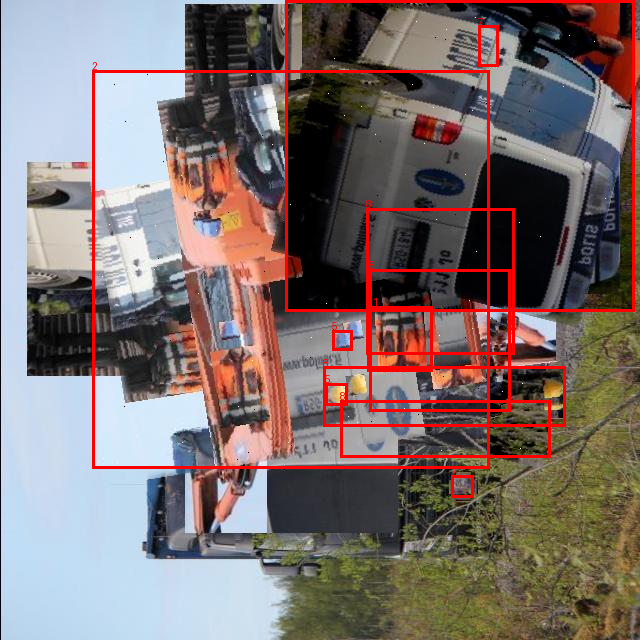

In [ ]:
from PIL import Image, ImageDraw

img_path = "../data/train/images/0043da1ff6622b4f_jpg.rf.66ef80eb7e836bce15ed6bc045746888.jpg"
label_path = "../data/train/labels/0043da1ff6622b4f_jpg.rf.66ef80eb7e836bce15ed6bc045746888.txt"

img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(img)

# Read YOLO labels
bboxes = []
with open(label_path, "r") as f:
    for line in f:
        class_id, xc, yc, bw, bh = map(float, line.strip().split())

        w, h = img.size 
        x1 = (xc - bw/2) * w
        y1 = (yc - bh/2) * h
        x2 = (xc + bw/2) * w
        y2 = (yc + bh/2) * h

        draw.rectangle([x1, y1, x2, y2], outline="red", width=3) # Draw BBOX
        draw.text((x1, y1 - 10), str(int(class_id)), fill="red") # Draw class_id

# Show image
display(img)

# 4. Inference

In [66]:
%matplotlib inline

0: 640x640 1 forklift, 8.8ms
1: 640x640 2 forklifts, 1 person, 8.8ms
2: 640x640 (no detections), 8.8ms
3: 640x640 1 forklift, 8.8ms
Speed: 10.9ms preprocess, 8.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


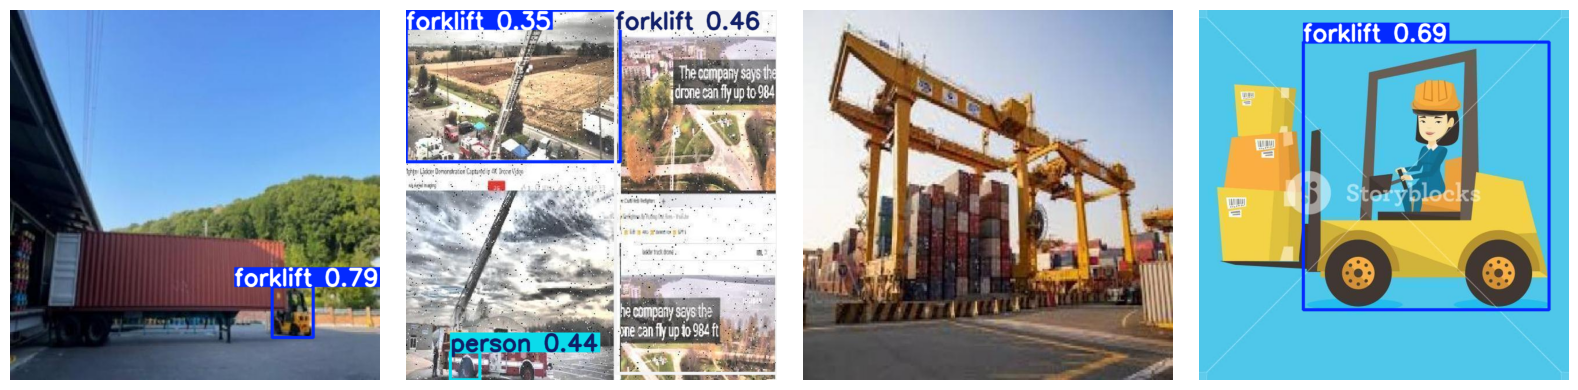

In [ ]:
VAL_SHOW_N = 4
val_imgs = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    #val_imgs.extend(glob.glob(os.path.join(val_dir, ext)))
    val_imgs.extend([p.as_posix() for p in Path(val_dir).rglob(ext)]) # Fixed path issue for glob in Windows
val_imgs = val_imgs[:VAL_SHOW_N]

pred = model.predict(source=val_imgs, imgsz=IMGSZ, conf=0.25)
# Mostrar con matplotlib (usamos 'plot' de ultralytics para guardar)
out_dir = "runs/predict_display"
os.makedirs(out_dir, exist_ok=True)

fig, axes = plt.subplots(1, len(val_imgs), figsize=(4*len(val_imgs), 4))
if len(val_imgs) == 1:
    axes = [axes]
for i, (ax, r) in enumerate(zip(axes, pred)):
    im = r.plot(line_width=4, color_mode='instance')  # numpy array con anotaciones, I modified line_with and color_mode for better visibility
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis('off')

    # OPTIONAL: guardar la imagen anotada en runs/predict_display
    cv2.imwrite(f"{out_dir}/pred_{i}.jpg", im)

plt.tight_layout()
plt.show()

# 5. Export and deploy

In [ ]:

export_dir = Path("artifacts")
export_dir.mkdir(parents=True, exist_ok=True)

best_ckpt = None
for p in Path("runs/detect").rglob("weights/best.pt"):
    best_ckpt = p
    break

if best_ckpt and best_ckpt.exists():
    target = export_dir / "model_best.pt"
    target.write_bytes(best_ckpt.read_bytes())
    print("Wheight export to:", target) # place where model is exported 
else:
    print("'best.pt' not found")

with open(export_dir / "classes.json", "w") as f:
    json.dump({"nc": int(nc), "names": class_names}, f, indent=2)

try:
    _ = model.export(format="onnx", imgsz=IMGSZ)
    onnx_file = None
    for p in Path(".").rglob("*.onnx"):
        onnx_file = p
        break
    if onnx_file:
        (export_dir / "model.onnx").write_bytes(onnx_file.read_bytes())
        print("ONNX export to:", export_dir / "model.onnx")
except Exception as e:
    print("Export ONNX not available:", e)


Wheight export to: artifacts\model_best.pt
Ultralytics 8.3.74  Python-3.10.11 torch-2.5.1+cu118 CPU (12th Gen Intel Core(TM) i7-12700K)

PyTorch: starting from 'runs\detect\train2\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 21, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ---------------------------------------- 16.5/16.5 MB 79.9 MB/s  0:00:00:01
   ---------------------------------------- 244.5/244.5 MB 81.8 MB/s  0:00:0201
  Attempting uninstall: protobuf----------- 0/8 [pyreadline3]
    Found existing installation: protobuf 3.20.3[pyreadline3]
    Uninstalling protobuf-3.20.3:---------- 0/8 [pyreadline3]
      Successfully uninstalled protobuf-3.20.38 [protobuf]e3]
   ---------------------------------------- 8/8 [onnxruntime-gpu]

requirements: AutoUpdate success  42.2s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements:

# 6. TODOs (for the candidate)
- [X] Analyze the class imbalance and propose strategies (weighting, augmented sampling, focal loss).
- [X] Tune hyperparameters (epochs, image size, augmentations) to improve mAP.
- [X] Record key metrics and justify the final baseline.
- [X] Prepare all necessary artifacts in artifacts/ for the inference service (API).

# 7. Appendix — Notes on relative paths
- This notebook reads data.yaml and infers the paths to images/ and labels/ for train/, val/, and test/.
- If you move data.yaml to another folder, adjust DATA_YAML_PATH.
- If the dataset was downloaded from Roboflow, keep the standard YOLO folder structure.